In [1]:
# # 在导入任何库之前添加
# import os
# os.environ["TORCH_COMPILE_DEBUG"] = "1"
# os.environ["TORCH_INDUCTOR_DISABLE_CUSTOM_PASSES"] = "1"
# 首先导入 torch 及其所有子模块
import torch
import torch.nn as nn
import torch.optim as optim

# 然后导入其他库
import pandas as pd
import numpy as np
import os
import re
import json
import time
import requests
from datetime import datetime
from typing import List, Dict, Tuple, Optional
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import platform
# 最后导入 transformers
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from textblob import TextBlob


# 添加以下导入
try:
    from IPython.display import display, Image
    in_notebook = True
except ImportError:
    in_notebook = False

# 设置matplotlib以支持中文和保存图像
plt.rcParams['figure.max_open_warning'] = 50  # 允许更多图形
# 设置中文字体支持 - 针对Mac环境
if platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = ['SimHei','Arial Unicode MS']
else:  # Windows或Linux
    plt.rcParams['font.family'] = ['SimHei', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

In [2]:
import pandas as pd
import numpy as np
import os
import re
import json
import time
import requests
import torch
from datetime import datetime
from typing import List, Dict, Tuple, Optional
from tqdm.auto import tqdm
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')

# 创建结果保存目录结构
RESULTS_DIR = "生成结果"
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)
    print(f"已创建结果保存目录: {os.path.abspath(RESULTS_DIR)}")
else:
    print(f"使用现有结果保存目录: {os.path.abspath(RESULTS_DIR)}")


# 设置关键词保存的文件夹
KEYWORD_DIR = os.path.join(RESULTS_DIR, "product_keywords")
if not os.path.exists(KEYWORD_DIR):
    os.makedirs(KEYWORD_DIR)
    print(f"已创建关键词目录: {os.path.abspath(KEYWORD_DIR)}")
else:
    print(f"使用现有关键词目录: {os.path.abspath(KEYWORD_DIR)}")

# 全局设置
API_KEY = "sk-2ea9416b45e04af6b6aa72d3c2ade52f"  # 输入您的qwen API密钥

# 如果未设置API_KEY，尝试从环境变量获取
if not API_KEY:
    API_KEY = os.environ.get("QWEN_API_KEY", "")

# 检查GPU状态
print(f"CUDA可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU型号: {torch.cuda.get_device_name(0)}")

# 检查MPS (Mac M1/M2 GPU)
try:
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        print("✅ MPS可用 - 将使用M1/M2 GPU加速")
        device = "mps"
    else:
        print("❌ MPS不可用")
        device = "cuda" if torch.cuda.is_available() else "cpu"
except:
    print("❓ 无法检测MPS状态")
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"将使用设备: {device}")


使用现有结果保存目录: C:\Users\admin\OneDrive\斗兽场\数据分析\数据分析整合\按客户划分-0416\致欧\生成结果
使用现有关键词目录: C:\Users\admin\OneDrive\斗兽场\数据分析\数据分析整合\按客户划分-0416\致欧\生成结果\product_keywords
CUDA可用: True
GPU型号: NVIDIA GeForce RTX 4090 D
❌ MPS不可用
将使用设备: cuda


In [3]:
# 1. 数据加载函数
def load_data(file_path):
    """加载数据文件，增强版支持多种编码和错误处理
    
    Args:
        file_path: 数据文件路径
        
    Returns:
        tuple: (DataFrame, 文件名前缀)
    """
    import pandas as pd
    import os
    import sys
    
    print(f"正在加载数据: {file_path}")
    
    # 检查文件是否存在
    if not os.path.exists(file_path):
        print(f"错误: 文件不存在: {file_path}")
        return None, None
    
    # 从文件路径中获取文件名（不含路径）
    file_name = os.path.basename(file_path)
    
    # 获取不含扩展名的文件名
    file_name_without_ext = os.path.splitext(file_name)[0]
    
    # 根据文件类型选择读取方法并处理编码问题
    try:
        if file_path.endswith('.xlsx'):
            try:
                df = pd.read_excel(file_path)
            except Exception as e:
                print(f"读取Excel文件时出错: {e}")
                return None, file_name_without_ext
                
        elif file_path.endswith('.csv'):
            # 尝试不同的编码
            encodings = ['utf-8-sig', 'utf-8', 'gbk', 'gb2312', 'latin1']
            for encoding in encodings:
                try:
                    df = pd.read_csv(file_path, encoding=encoding)
                    print(f"成功使用{encoding}编码读取CSV文件")
                    break
                except UnicodeDecodeError:
                    continue
                except Exception as e:
                    print(f"使用{encoding}编码读取时出错: {e}")
                    continue
            else:  # 如果所有编码都失败
                print("错误: 无法使用已知编码读取CSV文件")
                return None, file_name_without_ext
                
        else:
            print("不支持的文件格式，请提供.xlsx或.csv文件")
            return None, file_name_without_ext
            
    except Exception as e:
        print(f"加载数据时出现未知错误: {e}")
        return None, file_name_without_ext
    
    # 打印DataFrame的基本信息
    print(f"数据加载完成: {len(df)}行 x {len(df.columns)}列")
    print(f"数据列: {', '.join(df.columns.tolist())}")
    
    # 检查必要的列是否存在
    required_columns = ['content', 'Rating']
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        print(f"警告: 数据中缺少必要的列: {', '.join(missing_columns)}")
        
        # 尝试查找替代列
        if 'content' in missing_columns:
            # 尝试查找可能的评论内容列 - 增加了中文和英文可能的列名
            content_candidates = [
                'review', 'comment', 'text', 'review_text', 'comments', 
                '评论', '内容', '评论内容', '文本', '评价', 'content'
            ]
            # 不区分大小写的列名匹配
            df_cols_lower = {col.lower(): col for col in df.columns}
            
            for candidate in content_candidates:
                if candidate.lower() in df_cols_lower:
                    actual_col = df_cols_lower[candidate.lower()]
                    print(f"使用'{actual_col}'列作为评论内容")
                    df['content'] = df[actual_col]
                    if 'content' in missing_columns:
                        missing_columns.remove('content')
                    break
        
        if 'Rating' in missing_columns:
            # 尝试查找可能的评分列 - 增加了中文和英文可能的列名
            rating_candidates = [
                'rating', 'stars', 'score', 'rate', 'star', 
                '评分', '星级', '评级', '星数', '分数', 'Rating'
            ]
            # 不区分大小写的列名匹配
            df_cols_lower = {col.lower(): col for col in df.columns}
            
            for candidate in rating_candidates:
                if candidate.lower() in df_cols_lower:
                    actual_col = df_cols_lower[candidate.lower()]
                    print(f"使用'{actual_col}'列作为评分")
                    df['Rating'] = df[actual_col]
                    if 'Rating' in missing_columns:
                        missing_columns.remove('Rating')
                    break
    
    # 如果仍然缺少必要的列，则创建默认值
    if 'content' in missing_columns:
        print("警告: 未找到评论内容列，创建空列")
        df['content'] = ""
    
    if 'Rating' in missing_columns:
        print("警告: 未找到评分列，默认设置为3")
        df['Rating'] = 3
    
    # 确保Rating列为数值类型
    try:
        df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
        # 填充NaN值为中性评分3
        df['Rating'].fillna(3, inplace=True)
    except Exception as e:
        print(f"转换Rating列为数值时出错: {e}")
        df['Rating'] = 3
    
    # 移除内容为空的行
    orig_len = len(df)
    df = df[pd.notna(df['content']) & (df['content'].astype(str).str.strip() != '')]
    if len(df) < orig_len:
        print(f"已移除{orig_len - len(df)}行空内容")
    
    # 确保索引是整数
    df = df.reset_index(drop=True)
    
    print(f"成功加载数据，共{len(df)}条记录")
    
    return df, file_name_without_ext

# 2. 关键词生成函数
def generate_function_scenario_match_keywords(
    product_type: str, 
    api_key: Optional[str] = None,
    languages: List[str] = ["english", "spanish"],
    min_keywords: int = 100,
    output_dir: str = KEYWORD_DIR  # 修改为新的存储路径常量
) -> str:
    """使用大模型自动生成产品功能与使用场景正向匹配的关键词列表，支持多语言"""
    if not api_key:
        api_key = API_KEY
        if not api_key:
            print("警告: 未提供API密钥，无法生成关键词")
            return None
    
    # 创建输出目录
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 准备更完善的提示词 - 修改为关注功能-场景正向匹配
    language_str = ", ".join(languages)
    prompt_template = f"""
    As a product experience analyst specializing in e-commerce reviews, generate a comprehensive list of keywords and phrases that indicate positive matches between product functions and user scenarios for "{product_type}" products.
    
    Focus on these function-scenario match categories:
    1. Contextual utility (how specific product features excel in particular usage contexts)
    2. Situational effectiveness (how the product performs exceptionally well in specific situations)
    3. Environment-specific advantages (how features provide unique benefits in certain environments)
    4. Activity-optimized functions (how features enhance specific user activities)
    5. Scenario-specific performance (how the product performs beyond expectations in particular scenarios)
    6. Lifestyle integration (how the product seamlessly fits into specific lifestyle contexts)
    7. Specialized use cases (unique situations where the product functions particularly well)
    8. Unexpected convenience (surprising ways the product makes life easier in specific contexts)
    
    Requirements:
    - Languages: Primarily English, with some Spanish alternatives for common expressions
    - Format: Plain text, one keyword or phrase per line
    - Include both specific expressions (like "perfect for camping trips") and broader categories (like "excels in outdoor settings")
    - Include different expressions people use in reviews to express positive function-scenario matches
    - Include phrases that indicate delight, surprise, satisfaction with how features work in specific contexts
    - Focus on positive experiences where product features exceeded expectations in particular scenarios
    - Include expressions like "works perfectly when...", "especially useful for...", "perfect for...", "ideal when..."
    - Avoid mentioning specific product brands or models
    - Use generic terms that could apply to any product in this category
    - Return at least {min_keywords} relevant function-scenario match keywords
    - Include phrases from positive reviews where users describe specific situations where the product performed exceptionally
    - Include colloquial and informal expressions people use in reviews
    
    Return only the plain text list of keywords, without explanations, numbering or other formatting.
    """
    
    # 生成文件名 - 修改为function_scenario_match
    safe_product_type = product_type.replace(" ", "_").lower()
    filename = f"function_scenario_match_{safe_product_type}.txt"
    file_path = os.path.join(output_dir, filename)
    
    # 检查文件是否已存在
    if os.path.exists(file_path):
        print(f"功能-场景匹配关键词文件已存在: {os.path.abspath(file_path)}，跳过API调用")
        return file_path
    
    # 尝试多种API调用方式
    keyword_text = None
    
    # 方法1: 使用OpenAI兼容模式调用阿里云灵积模型
    try:
        print(f"正在为 {product_type} 生成多语言功能-场景匹配关键词列表(方法1)...")
        
        from openai import OpenAI
        
        client = OpenAI(
            api_key=api_key,
            base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
        )
        
        completion = client.chat.completions.create(
            model="qwen-max",  # 或使用其他可用模型
            messages=[
                {"role": "system", "content": "You are a product experience analyst with expertise in identifying how product functions positively match with user scenarios."},
                {"role": "user", "content": prompt_template}
            ],
            temperature=0.3,  # 稍微提高创造性以获取更多变体
            max_tokens=4000   # 增加token限制以获取更多关键词
        )
        
        keyword_text = completion.choices[0].message.content.strip()
        print(f"方法1成功获取关键词，长度: {len(keyword_text.splitlines())} 行")
        
    except Exception as e:
        print(f"方法1生成关键词时出错: {e}")
    
    # 方法2: 使用原始的requests调用通义千问API
    if not keyword_text:
        try:
            print(f"正在为 {product_type} 生成多语言功能-场景匹配关键词列表(方法2)...")
            
            import requests
            
            headers = {
                "Content-Type": "application/json",
                "Authorization": f"Bearer {api_key}"
            }
            
            payload = {
                "model": "qwen-max",
                "messages": [
                    {"role": "system", "content": "You are a product experience analyst with expertise in identifying how product functions positively match with user scenarios."},
                    {"role": "user", "content": prompt_template}
                ],
                "temperature": 0.3,
                "max_tokens": 4000
            }
            
            response = requests.post(
                "https://api.qwen.ai/v1/chat/completions",
                headers=headers,
                json=payload,
                verify=False
            )
            
            if response.status_code == 200:
                result = response.json()
                keyword_text = result["choices"][0]["message"]["content"].strip()
                print(f"方法2成功获取关键词，长度: {len(keyword_text.splitlines())} 行")
        
        except Exception as e:
            print(f"方法2生成关键词时出错: {e}")
    
    # 方法3: 使用通用的功能-场景匹配模板生成基础关键词
    if not keyword_text:
        try:
            print(f"正在为 {product_type} 生成通用功能-场景匹配关键词列表(方法3)...")
            
            # 扩展的通用功能-场景匹配类别和模板
            match_categories = [
                # 英文功能-场景匹配关键词
                "perfect for", "works great when", "ideal for", "excellent in", 
                "performs best during", "shines when used for", "especially useful for", "convenient for",
                "made my experience better when", "excels at", "surprisingly good for", "exceeded expectations when",
                
                # 英文场景-体验关键词
                "perfect companion for", "made a huge difference during", "game changer for", "essential for",
                "exactly what I needed for", "brilliant for", "fantastic when", "amazing for",
                "couldn't be better for", "works flawlessly during", "extremely helpful for", "designed perfectly for",
                
                # 英文特定场景关键词
                "during travel", "on vacation", "in the office", "at home", "outdoors",
                "in bad weather", "in the kitchen", "on the go", "while commuting", "in the car",
                "during workouts", "while hiking", "at the beach", "in the garden", "for daily use",
                
                # 英文情感体验关键词
                "love how it works for", "impressed by its performance during", "delighted with how it handles",
                "amazed at how well it works when", "so pleased with how it performs during", "appreciate how it helps with",
                "thrilled with its capabilities when", "completely satisfied using it for", "enjoy using it during",
                
                # 英文实用性关键词
                "saved me time when", "made it easier to", "simplified my routine for", "streamlined my process of",
                "enhanced my experience of", "improved my ability to", "solved my problem with", "addressed my need for", 
                "transformed how I", "eliminated hassle when", "optimized my workflow for",
                
                # 英文场景比较关键词
                "better than others for", "outperforms alternatives when", "superior for", "stands out when used for",
                "beats competition at", "unmatched for", "no comparison when it comes to", "best option for",
                "top choice for", "leader in handling", "dominates when it comes to",
                
                # 西班牙语功能-场景匹配关键词
                "perfecto para", "funciona muy bien cuando", "ideal para", "excelente en", 
                "rinde mejor durante", "destaca cuando se usa para", "especialmente útil para", "conveniente para",
                "mejoró mi experiencia cuando", "sobresale en", "sorprendentemente bueno para", "superó mis expectativas cuando"
            ]
            
            # 添加产品特定的通用匹配表述
            product_words = product_type.lower().split()
            specific_matches = []
            
            for word in product_words:
                if len(word) > 2:  # 忽略太短的词
                    specific_matches.extend([
                        f"perfect {word} for", f"{word} works great when", f"{word} ideal for travel",
                        f"{word} excellent in outdoor settings", f"{word} performs best during summer",
                        f"{word} shines when used for daily tasks", f"{word} especially useful for busy people",
                        f"{word} convenient for small spaces", f"{word} perfect companion for adventures",
                        f"{word} game changer for professionals", f"{word} essential for families",
                        f"{word} makes life easier when", f"{word} solves problems during", f"{word} enhances experience of"
                    ])
            
            # 合并关键词
            all_keywords = match_categories + specific_matches
            
            # 去重并排序
            all_keywords = sorted(set(all_keywords))
            
            keyword_text = "\n".join(all_keywords)
            print(f"方法3成功生成通用功能-场景匹配关键词，长度: {len(all_keywords)} 行")
            
        except Exception as e:
            print(f"方法3生成关键词时出错: {e}")
    
    # 如果所有方法都失败，返回最基本的通用功能-场景匹配关键词
    if not keyword_text:
        print("所有方法都失败，使用最基本的通用功能-场景匹配关键词")
        
        basic_keywords = [
            "perfect for", "works great when", "ideal for", "excellent in", 
            "performs best during", "especially useful for", "convenient for",
            "great for", "exactly what I needed for", "makes life easier when",
            "perfecto para", "funciona muy bien cuando", "ideal para", "excelente en"
        ]
        
        keyword_text = "\n".join(basic_keywords)
    
    # 保存到文件
    try:
        with open(file_path, "w", encoding="utf-8") as f:
            f.write(keyword_text)
        
        keyword_count = len(keyword_text.splitlines())
        print(f"已生成 {keyword_count} 个功能-场景匹配关键词并保存到: {file_path}")
        return file_path
    
    except Exception as e:
        print(f"保存关键词文件时出错: {e}")
        return None


# 从文件加载关键词
def load_function_scenario_match_keywords(
    product_type: str,
    keyword_dir: str = KEYWORD_DIR
) -> List[str]:
    """从文件加载特定产品的功能-场景匹配关键词"""
    # 构建文件路径
    safe_product_type = product_type.replace(" ", "_").lower()
    file_path = os.path.join(keyword_dir, f"function_scenario_match_{safe_product_type}.txt")
    
    # 检查文件是否存在
    if not os.path.exists(file_path):
        print(f"警告: 未找到产品'{product_type}'的功能-场景匹配关键词文件: {file_path}")
        return []
    
    # 读取文件
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            keywords = [line.strip() for line in f if line.strip()]
        
        print(f"已加载 {len(keywords)} 个功能-场景匹配关键词，来自: {file_path}")
        return keywords
    
    except Exception as e:
        print(f"读取功能-场景匹配关键词文件时出错: {e}")
        return []



In [4]:
# 3. 模型加载函数
def setup_sentiment_model():
    """设置多语言情感分析模型"""
    print("正在加载多语言情感分析模型...")
    
    try:
        model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name)
        
        # 移至GPU/MPS
        if device == "cuda" and torch.cuda.is_available():
            model = model.to("cuda")
            print("情感分析模型已加载至CUDA GPU")
        elif device == "mps":
            model = model.to("mps")
            print("情感分析模型已加载至MPS (M1/M2 GPU)")
        else:
            print("情感分析模型将使用CPU")
            
        return model, tokenizer
    except Exception as e:
        print(f"加载情感分析模型出错: {e}")
        return None, None

def setup_zeroshot_model():
    """设置多语言零样本分类模型"""
    print("正在加载多语言零样本分类模型...")
    
    try:
        # 使用支持XNLI的多语言模型，支持多种语言
        device_id = 0 if device == "cuda" and torch.cuda.is_available() else -1
        # MPS不直接支持pipeline，所以使用CPU
        if device == "mps":
            device_id = -1
            print("注意: 零样本分类将使用CPU，因为pipeline不支持MPS")
            
        classifier = pipeline(
            "zero-shot-classification",
            model="joeddav/xlm-roberta-large-xnli",
            device=device_id
        )
        print("零样本分类模型加载成功")
        return classifier
    except Exception as e:
        print(f"加载零样本分类模型出错: {e}")
        return None



# 4. 情感分析函数
def analyze_sentiment(text, model, tokenizer, threshold=0.6):
    """使用多语言模型进行情感分析"""
    if pd.isna(text) or not text:
        return "neutral", 0.0
        
    # 预处理
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    if device == "cuda" and torch.cuda.is_available():
        inputs = {k: v.to("cuda") for k, v in inputs.items()}
    elif device == "mps":
        inputs = {k: v.to("mps") for k, v in inputs.items()}
    
    # 情感预测
    with torch.no_grad():
        outputs = model(**inputs)
        scores = torch.nn.functional.softmax(outputs.logits, dim=1)
        
    # 获取结果
    sentiment_id = scores.argmax().item()
    confidence = scores[0][sentiment_id].item()
    
    # 映射情感ID到标签
    labels = ["negative", "neutral", "positive"]
    sentiment = labels[sentiment_id]
    
    return sentiment, confidence


In [5]:
def extract_function_scenario_matches(text, match_keywords=None, classifier=None, product_type=None, debug=False):
    """整合多种方法提取产品功能与使用场景的正向匹配描述，增强中文支持，确保提取多个匹配点
    
    Args:
        text: 评论文本内容
        match_keywords: 预定义的功能-场景匹配关键词列表
        classifier: 零样本分类器（可选）
        product_type: 产品类型（可选，用于上下文理解）
        debug: 是否输出调试信息
        
    Returns:
        list: 包含功能-场景匹配信息的字典列表，每个字典包含'match'和'context'
    """
    # 确保文本正确编码
    try:
        if isinstance(text, str):
            text = text.encode('utf-8').decode('utf-8')
        else:
            text = str(text)
    except UnicodeError:
        text = str(text)
    if pd.isna(text) or not text or len(str(text).strip()) < 5:
        if debug:
            print("评论文本为空或太短，跳过")
        return []
    
    content = str(text).lower()
    original_text = str(text)
    matches = []  # 存储提取的功能-场景匹配
    
    # 检测语言（简单方法）
    chinese_char_count = sum(1 for c in content if '\u4e00' <= c <= '\u9fff')
    is_chinese = chinese_char_count > len(content) * 0.3
    
    if debug:
        print(f"\n处理评论: {text[:100]}..." if len(text) > 100 else f"\n处理评论: {text}")
        print(f"语言检测: {'中文' if is_chinese else '非中文'} (中文字符比例: {chinese_char_count/len(content):.2f})")
    
    # 分词方式根据语言调整
    if is_chinese:
        content_words = set(content)
    else:
        content_words = set(re.findall(r'\b\w+\b', content.lower()))
    
    content_length = len(content)
    
    # 计算动态阈值 - 降低阈值以捕获更多表达
    if content_length < 50:
        threshold = 0.45  # 进一步降低阈值
    elif content_length > 200:
        threshold = 0.55  # 进一步降低阈值
    else:
        # 线性增长
        threshold = 0.45 + ((content_length - 50) / 150) * 0.10
    
    if debug:
        print(f"内容长度: {content_length}, 动态阈值: {threshold:.2f}")
        print(f"可用关键词数量: {len(match_keywords) if match_keywords else 0}")
    
    # 1. 使用零样本分类 - 保留原有模板，但确保多标签分类
    if classifier and match_keywords:
        try:
            if debug:
                print("开始零样本分类...")
            
            # 保留原有模板，但修改为功能-场景匹配
            if is_chinese:
                templates = [
                    "用户认为产品在{}方面表现出色",
                    "顾客表示产品非常适合{}",
                    "评论提到产品在{}场景下使用效果极佳",
                    "用户认为产品功能完美适合{}",
                    "评论表扬产品在{}情况下的表现"
                ]
            else:
                templates = [
                    "Users find the product excellent for {}",
                    "Customers say the product is perfect for {}",
                    "The review mentions the product works great in {}",
                    "Users find the product features ideal for {}",
                    "The review praises how the product performs during {}"
                ]
            
            # 预过滤可能的关键词以减少计算量 - 使用更宽松的过滤条件
            filtered_keywords = []
            for keyword in match_keywords:
                keyword = keyword.strip().lower()
                if not keyword:
                    continue
                
                # 使用启发式规则过滤，但更宽松
                if is_chinese:
                    # 中文：只要有一个字符匹配就考虑
                    if any(char in content for char in keyword):
                        filtered_keywords.append(keyword)
                else:
                    # 英文：只要有一个词匹配就考虑
                    keyword_parts = keyword.split()
                    if any(part in content_words for part in keyword_parts):
                        filtered_keywords.append(keyword)
            
            # 确保有足够的关键词
            if len(filtered_keywords) < 10:  # 增加到10个
                if is_chinese:
                    common_matches = [
                        "日常使用", "户外活动", "家庭场景", "旅行途中", "工作环境", 
                        "休闲时光", "运动时刻", "特殊场合", "多功能使用", "便携携带",
                        "长时间使用", "极端环境", "精准操作", "快速上手", "家庭聚会"
                    ]
                else:
                    common_matches = [
                        "daily use", "outdoor activities", "home environment", 
                        "travel situations", "work setting", "leisure time", 
                        "during exercise", "special occasions", "versatile uses", 
                        "on the go", "extended use", "extreme conditions", 
                        "precise operation", "quick start", "family gatherings"
                    ]
                for match in common_matches:
                    if match not in filtered_keywords:
                        filtered_keywords.append(match)
            
            # 限制数量避免过多计算，但增加上限
            filtered_keywords = filtered_keywords[:50] if len(filtered_keywords) > 50 else filtered_keywords
            
            if debug:
                print(f"过滤后的关键词: {len(filtered_keywords)}个")
                if len(filtered_keywords) <= 10:
                    print(f"关键词列表: {filtered_keywords}")
            
            # 收集所有模板的结果
            all_matches = {}
            for template in templates:
                if debug:
                    print(f"使用模板: {template}")
                
                # 显式设置multi_label=True确保提取多个匹配
                result = classifier(
                    content, 
                    filtered_keywords,
                    hypothesis_template=template,
                    multi_label=True
                )
                
                # 打印调试信息
                if debug:
                    print(f"  - 得分前三的功能-场景匹配:")
                    for i, (label, score) in enumerate(zip(result["labels"], result["scores"])):
                        if i < 3:
                            print(f"    {label}: {score:.3f}")
                
                # 累积结果，取最高分
                for label, score in zip(result["labels"], result["scores"]):
                    if label in all_matches:
                        all_matches[label] = max(all_matches[label], score)
                    else:
                        all_matches[label] = score
            
            # 使用动态阈值提取匹配，但确保提取多个
            accepted_count = 0
            for label, score in sorted(all_matches.items(), key=lambda x: x[1], reverse=True):
                if score >= threshold or (accepted_count < 2 and score >= threshold * 0.9):  # 确保至少提取前3个高分匹配
                    pos = content.find(label.lower())
                    context = ""
                    
                    if pos >= 0:
                        # 提取上下文
                        context_start = max(0, pos - 20)
                        context_end = min(len(original_text), pos + len(label) + 20)
                        context = original_text[context_start:context_end]
                    else:
                        # 如果找不到精确位置，使用近似位置
                        context = original_text[:min(50, len(original_text))]
                    
                    # 添加功能-场景匹配和上下文
                    match_info = {
                        'match': label,
                        'score': score,
                        'context': context if context else original_text[:50]
                    }
                    matches.append(match_info)
                    accepted_count += 1
                        
                    if debug:
                        print(f"✓ 零样本分类器接受: {label} (得分: {score:.3f})")
                elif debug and score >= threshold * 0.7:  # 显示接近阈值的匹配
                    print(f"? 零样本分类器接近阈值: {label} (得分: {score:.3f})")
                    
        except Exception as e:
            print(f"零样本分类错误: {e}")

    # 2. 使用更宽松的关键词匹配，确保匹配多个关键词
    if match_keywords:
        if debug:
            print("开始关键词匹配...")
        
        # 按长度排序关键词，优先匹配长关键词
        sorted_keywords = sorted(match_keywords, key=len, reverse=True)
        
        for keyword in sorted_keywords:
            keyword = keyword.strip().lower()
            if not keyword or len(keyword) < 2:  # 降低长度要求
                continue
                
            # 精确匹配 - 直接包含关键词
            matches_found = []
            start_pos = 0
            while True:
                pos = content.find(keyword, start_pos)
                if pos == -1:
                    break
                matches_found.append(pos)
                start_pos = pos + len(keyword)
            
            # 如果找到多个匹配，全部添加
            for pos in matches_found:
                context_start = max(0, pos - 20)
                context_end = min(len(original_text), pos + len(keyword) + 20)
                context = original_text[context_start:context_end]
                
                match_info = {
                    'match': keyword,
                    'score': 1.0,  # 精确匹配给予最高分
                    'context': context
                }
                matches.append(match_info)
                
                if debug and len(matches_found) > 0:
                    print(f"✓ 关键词精确匹配: {keyword} (找到{len(matches_found)}处)")
            
            if matches_found:
                continue
                
            # 部分匹配 - 针对多词短语
            if is_chinese:
                # 中文关键词匹配 - 按字符匹配，确保超过50%的字符匹配
                matched_chars = sum(1 for char in keyword if char in content_words)
                match_ratio = matched_chars / len(keyword) if len(keyword) > 0 else 0
                
                # 对于中文匹配，使用更宽松的匹配率(50%)
                if match_ratio >= 0.75:
                    # 使用近似位置
                    context = original_text[:min(50, len(original_text))]
                    
                    match_info = {
                        'match': keyword,
                        'score': match_ratio,  # 使用匹配率作为分数
                        'context': context
                    }
                    matches.append(match_info)
                    
                    if debug:
                        print(f"✓ 中文关键词部分匹配: {keyword} (匹配率: {match_ratio:.2f})")
            else:
                # 英文关键词匹配 - 分词后匹配
                keyword_parts = keyword.split()
                if len(keyword_parts) > 1:
                    # 计算内容中包含关键词中词汇的比例
                    matched_parts = sum(1 for part in keyword_parts if part in content_words)
                    match_ratio = matched_parts / len(keyword_parts) if len(keyword_parts) > 0 else 0
                    
                    # 对于匹配，使用更宽松的匹配率(50%)
                    if match_ratio >= 0.75:
                        # 使用近似位置
                        context = original_text[:min(50, len(original_text))]
                        
                        match_info = {
                            'match': keyword,
                            'score': match_ratio,  # 使用匹配率作为分数
                            'context': context
                        }
                        matches.append(match_info)
                        
                        if debug:
                            print(f"✓ 英文关键词部分匹配: {keyword} (匹配率: {match_ratio:.2f})")

    # 3. 使用语义模式识别 - 修改为功能-场景匹配的模式
    if debug:
        print("开始语义模式识别...")
    
    if is_chinese:
        match_patterns = [
            r'(完美适合|非常适合|特别适用于)([\w\s，。！？、]{1,30})',
            r'(特别好用于|表现出色在|功能强大)([\w\s，。！？、]{1,30})',
            r'(当[\w\s，。！？、]{1,30})(时非常好用|时效果最佳)',
            r'(在[\w\s，。！？、]{1,30})(情况下特别实用|环境中表现出色)',
            r'(满足|解决了)([\w\s，。！？、]{1,30})(的需求|的问题)',
            r'(超出期望|令人惊喜)([\w\s，。！？、]{1,30})'
        ]
    else:
        match_patterns = [
            r'(perfect for|works great when|ideal for)([\w\s]{1,30})',
            r'(excellent in|performs best during|shines when)([\w\s]{1,30})',
            r'(especially useful for|convenient for|perfect companion for)([\w\s]{1,30})',
            r'(made a huge difference|game changer for|essential for)([\w\s]{1,30})',
            r'(exceeded expectations|surprisingly good for|amazed at)([\w\s]{1,30})',
            r'(love how it|impressed by|delighted with)([\w\s]{1,30})'
        ]
    
    pattern_matches_count = 0
    for pattern in match_patterns:
        matches_found = re.finditer(pattern, content)
        for match in matches_found:
            phrase = match.group(0)
            pos = match.start()
            context_start = max(0, pos - 20)
            context_end = min(len(original_text), pos + len(phrase) + 20)
            context = original_text[context_start:context_end]
            
            match_info = {
                'match': phrase,
                'score': 0.8,  # 给模式匹配一个较高的默认分数
                'context': context
            }
            matches.append(match_info)
            
            pattern_matches_count += 1
            if debug and pattern_matches_count <= 5:  # 只显示前5个匹配
                print(f"✓ 识别到功能-场景匹配模式: {phrase}")

    # 4. 从"优点"或"Pros"部分提取
    highlights_section = None
    highlights_start = -1
    
    if is_chinese:
        markers = ['优点:', '优点', '亮点:', '亮点', '好处:', '好处']
    else:
        markers = ['pros:', 'pros', 'highlights:', 'highlights', 'advantages:', 'advantages']
    
    for marker in markers:
        if marker in content:
            highlights_start = content.find(marker)
            highlights_end = len(content)
            
            # 寻找结束位置
            end_markers = ['\n\n', '\r\n\r\n', '缺点', '不足', 'cons']
            for end_marker in end_markers:
                pos = content.find(end_marker, highlights_start + len(marker))
                if pos > highlights_start:
                    highlights_end = min(highlights_end, pos)
            
            highlights_section = content[highlights_start:highlights_end]
            break
    
    if highlights_section and highlights_start >= 0:  # 确保找到有效的优点部分
        highlight_matches = re.finditer(r'[-*•]\s*([^\n\r]+)', highlights_section)
        highlight_count = 0
        for match in highlight_matches:
            item = match.group(1).strip()
            if len(item) >= 3:
                try:
                    pos = highlights_start + match.start()
                    if pos >= 0:  # 验证位置有效性
                        context_start = max(0, pos - 20)
                        context_end = min(len(original_text), pos + len(item) + 20)
                        context = original_text[context_start:context_end]
                        
                        match_info = {
                            'match': item,
                            'score': 0.9,  # 给予较高分数
                            'context': context
                        }
                        matches.append(match_info)
                        
                        highlight_count += 1
                        if debug:
                            print(f"✓ 从优点部分提取: {item}")
                except Exception as e:
                    if debug:
                        print(f"处理优点项时出错: {e}")
                    continue
        
        if debug and highlight_count > 0:
            print(f"从优点部分提取了 {highlight_count} 个功能-场景匹配")

    # 5. 分句分析，尝试从每个句子中提取功能-场景匹配
    sentences = re.split(r'[.!?。！？]', original_text)
    sentences = [s.strip() for s in sentences if len(s.strip()) > 10]  # 只考虑较长的句子
    
    if debug and len(sentences) > 1:
        print(f"评论分为 {len(sentences)} 个句子进行分析")
    
    # 尝试从每个句子中提取额外的功能-场景匹配表达
    if is_chinese:
        extra_patterns = [
            r'非常适合([\w\s，。！？、]{1,30})',
            r'完美解决([\w\s，。！？、]{1,30})',
            r'超级好用于([\w\s，。！？、]{1,30})',
            r'效果出色在([\w\s，。！？、]{1,30})',
            r'使用场景([\w\s，。！？、]{1,30})',
            r'功能强大([\w\s，。！？、]{1,30})',
            r'表现优异([\w\s，。！？、]{1,30})'
        ]
    else:
        extra_patterns = [
            r'love how it ([\w\s]{1,30})',
            r'great for ([\w\s]{1,30})',
            r'perfect when ([\w\s]{1,30})',
            r'works best ([\w\s]{1,30})',
            r'excellent for ([\w\s]{1,30})',
            r'ideal in ([\w\s]{1,30})',
            r'fantastic at ([\w\s]{1,30})'
        ]
    
    extra_match_count = 0
    for i, sentence in enumerate(sentences):
        sentence_lower = sentence.lower()
        
        # 跳过已经处理过的句子
        already_processed = False
        for match_info in matches:
            if sentence in match_info['context'] or match_info['context'] in sentence:
                already_processed = True
                break
        
        if already_processed:
            continue
        
        # 对每个句子应用额外的模式
        for pattern in extra_patterns:
            matches_found = re.finditer(pattern, sentence_lower)
            for match in matches_found:
                phrase = match.group(0)
                
                match_info = {
                    'match': phrase,
                    'score': 0.7,  # 给予较低分数
                    'context': sentence
                }
                matches.append(match_info)
                
                extra_match_count += 1
                if debug and extra_match_count <= 3:
                    print(f"✓ 从句子{i+1}中提取额外功能-场景匹配: {phrase}")
    
    # 6. 如果匹配数量很少，尝试使用更宽松的匹配
    if len(matches) < 2 and match_keywords:
        if debug:
            print("功能-场景匹配数量较少，尝试更宽松的匹配...")
        
        # 尝试更宽松的关键词匹配
        for keyword in match_keywords:
            keyword = keyword.strip().lower()
            if not keyword or len(keyword) < 3:
                continue
                
            # 检查是否已经匹配过
            already_matched = False
            for match_info in matches:
                if keyword in match_info['match'].lower() or match_info['match'].lower() in keyword:
                    already_matched = True
                    break
                    
            if already_matched:
                continue
                
            # 非常宽松的匹配 - 只要有部分重叠
            keyword_parts = keyword.split() if not is_chinese else list(keyword)
            for part in keyword_parts:
                if len(part) >= 2 and part in content:
                    pos = content.find(part)
                    context_start = max(0, pos - 20)
                    context_end = min(len(original_text), pos + len(part) + 20)
                    context = original_text[context_start:context_end]
                    
                    match_info = {
                        'match': keyword,
                        'score': 0.5,  # 给予较低分数
                        'context': context
                    }
                    matches.append(match_info)
                    
                    if debug:
                        print(f"✓ 宽松匹配接受关键词: {keyword} (匹配部分: {part})")
                    break

    # 7. 去重并标准化
    unique_matches = []
    seen_texts = set()
    
    # 按分数排序，优先保留高分匹配
    sorted_matches = sorted(matches, key=lambda x: x['score'], reverse=True)
    
    for match_info in sorted_matches:
        match = match_info['match'].strip()
        match_lower = match.lower()
        
        if not match_lower:
            continue
            
        # 检查是否与已有匹配过于相似
        should_add = True
        for seen_text in seen_texts:
            # 如果两个匹配有超过80%的重叠，认为是相似的
            if match_lower in seen_text or seen_text in match_lower or \
               (len(match_lower) > 5 and len(seen_text) > 5 and \
                (match_lower[:5] == seen_text[:5] or match_lower[-5:] == seen_text[-5:])):
                should_add = False
                break
        
        if should_add:
            seen_texts.add(match_lower)
            unique_matches.append({
                'match': match,
                'context': match_info['context']
            })
    
    if debug:
        print(f"最终提取的功能-场景匹配: {len(unique_matches)}个")
        for match_info in unique_matches[:min(5, len(unique_matches))]:
            print(f"  - {match_info['match']}")
    
    # 限制返回数量，但返回完整信息
    return unique_matches[:30]  # 进一步增加最大数量


In [6]:
# 6. 缺陷重要性计算函数
def calculate_match_importance_scores(df, match_data, method_type="ZeroShot"):
    """
    计算每个功能-场景匹配的重要性分数
    
    参数:
    - df: 原始数据DataFrame
    - match_data: 包含功能-场景匹配和相关索引的字典
    - method_type: 提取方法类型
    
    返回:
    - scores: 功能-场景匹配重要性分数字典
    - match_examples: 功能-场景匹配样例字典，包含索引和原始内容
    """
    scores = {}
    match_examples = {}
    
    for match, indices in tqdm(match_data.items(), desc="计算重要性分数"):
        count = len(indices)
        
        # 评分加权
        rating_weight = 0
        sentiment_weight = 0
        
        # 收集样例 - 存储为字典格式 {索引: 内容}
        examples = {}
        
        # 处理该功能-场景匹配对应的所有评论
        for idx in indices:
            if idx in df.index:
                # 获取评论和评分
                review = df.loc[idx, 'content']
                rating = df.loc[idx, 'Rating']
                
                # 评分权重 - 正向评分权重，高评分权重更高
                if not pd.isna(rating):
                    rating_weight += rating / 5.0  # 评分5最高权重，评分1最低权重
                
                # 情感分析 - 正向情感权重，正面情感权重更高
                if isinstance(review, str) and review.strip():
                    try:
                        sentiment = TextBlob(review).sentiment.polarity
                        # 转换到[0,2]范围，正面情感得分高
                        sentiment_weight += (1.0 + sentiment)  # 情感越正面，权重越高
                    except:
                        sentiment_weight += 1.0  # 中性情感
                
                # 保存样例（最多5个）
                if len(examples) < 5 and isinstance(review, str) and review.strip():
                    examples[int(idx)] = review  # 确保idx是整数
        
        # 计算平均权重
        n = len(indices) if indices else 1
        avg_rating_weight = rating_weight / n
        avg_sentiment_weight = sentiment_weight / n if sentiment_weight > 0 else 1.0
        
        # 计算特异性分数
        if method_type == "TextRank":
            # TextRank提取的是句子，用不同的特异性计算
            specificity = min(1.0, len(match.split()) / 20)
        else:
            # ZeroShot提取的是短语
            specificity = min(len(match.split()) / 3, 1.5)
        
        # 计算最终分数：频率(50%) + 评分(20%) + 情感(20%) + 特异性(10%)
        final_score = (0.5 * count) + (0.2 * avg_rating_weight * n) + \
                     (0.2 * avg_sentiment_weight * n) + (0.1 * specificity * n)
        
        scores[match] = final_score
        match_examples[match] = examples
    
    return scores, match_examples


In [7]:
def process_dataframe_for_matches(df, product_type, rating_range=None, content_length_range=None, 
                              content_length_method='words', content_column='content', 
                              batch_size=16, debug_mode=True):
    """处理数据框，提取功能-场景匹配并计算频率，确保正确关联原始评论
    
    Args:
        df: 包含评论数据的DataFrame
        product_type: 产品类型
        rating_range: 评分范围元组(min, max)
        content_length_range: 内容长度范围元组(min, max)
        content_length_method: 内容长度计算方法，'chars'或'words'
        content_column: 包含评论内容的列名
        batch_size: 批处理大小
        debug_mode: 是否输出调试信息
        
    Returns:
        tuple: (功能-场景匹配详情df, 功能-场景匹配统计df)
    """
    import pandas as pd
    import re
    
    print(f"正在分析评论以提取功能-场景匹配...")
    
    # 打印原始数据信息
    print(f"原始数据包含 {len(df)} 条记录，索引范围: {df.index.min()} 到 {df.index.max()}")
    
    # 保存原始索引 - 关键步骤
    df_with_index = df.copy()
    df_with_index['original_index'] = df_with_index.index
    
    # 根据评分筛选
    if rating_range and 'Rating' in df_with_index.columns:
        min_rating, max_rating = rating_range
        review_sample = df_with_index[(df_with_index['Rating'] >= min_rating) & 
                                     (df_with_index['Rating'] <= max_rating)].copy()
        if debug_mode:
            print(f"评分筛选后，数据减少到 {len(review_sample)} 条")
    else:
        review_sample = df_with_index.copy()
    
    # 打印筛选后的索引范围
    print(f"筛选后的索引范围: {review_sample['original_index'].min()} 到 {review_sample['original_index'].max()}")
    
    # 根据内容长度筛选
    if content_length_range and content_column in review_sample.columns:
        original_count = len(review_sample)
        print(f"正在按内容长度筛选，方法为: {content_length_method}...")
        
        # 添加内容长度列
        review_sample['content_length'] = review_sample[content_column].apply(
            lambda x: calculate_content_length(x, method=content_length_method)
        )
        
        # 调试: 检查内容长度分布
        if debug_mode:
            lengths = review_sample['content_length']
            print(f"内容长度统计（{content_length_method}）:")
            print(f"- 最小长度: {lengths.min()}")
            print(f"- 最大长度: {lengths.max()}")
            print(f"- 平均长度: {lengths.mean():.1f}")
            print(f"- 长度分布: <10: {(lengths < 10).sum()}, 10-50: {((lengths >= 10) & (lengths <= 50)).sum()}, >50: {(lengths > 50).sum()}")
        
        min_len, max_len = content_length_range
        
        # 筛选最小长度
        if min_len is not None:
            review_sample = review_sample[review_sample['content_length'] >= min_len]
                
        # 筛选最大长度
        if max_len is not None:
            review_sample = review_sample[review_sample['content_length'] <= max_len]
            
        print(f"按内容长度筛选后，从{original_count}条减少到{len(review_sample)}条")
        print(f"内容长度筛选后的索引范围: {review_sample['original_index'].min()} 到 {review_sample['original_index'].max()}")
    
    # 如果没有评论，返回空数据框
    if len(review_sample) == 0:
        print("没有找到符合条件的评论")
        return pd.DataFrame(), pd.DataFrame()
    
    # 加载功能-场景匹配关键词
    match_keywords = load_function_scenario_match_keywords(product_type)
    if not match_keywords:
        print(f"警告: 无法获取'{product_type}'的功能-场景匹配关键词，尝试生成")
        keywords_file = generate_function_scenario_match_keywords(product_type)  # 调用生成关键词的函数
        if keywords_file:
            match_keywords = load_function_scenario_match_keywords(product_type)
        
        if not match_keywords:
            print("无法生成功能-场景匹配关键词，将使用零样本分类")
    
    print(f"已加载 {len(match_keywords) if match_keywords else 0} 个功能-场景匹配关键词，来自: {get_function_scenario_keywords_path(product_type)}")
    
    # 调试: 显示部分关键词
    if debug_mode and match_keywords:
        print("关键词样本:")
        for kw in match_keywords[:10]:  # 只显示前10个
            print(f"- {kw}")
    
    # 确定要处理的样本
    if debug_mode:
        # 调试模式下只处理少量数据
        max_reviews_to_process = min(20, len(review_sample))
        review_sample_to_process = review_sample.iloc[:max_reviews_to_process].copy()
        print(f"调试模式: 仅处理前{max_reviews_to_process}条评论")
    else:
        # 非调试模式处理全部数据
        review_sample_to_process = review_sample.copy()
        print(f"处理全部 {len(review_sample)} 条评论")
    
    # 创建长格式数据的列表和功能-场景匹配统计
    match_rows = []
    match_counts = {}
    processed_count = 0
    
    # 创建功能-场景匹配到索引的映射字典
    match_to_indices = {}
    
    try:
        # 尝试使用datasets处理，避免pipeline警告
        from datasets import Dataset
        from transformers import pipeline
        
        print("使用Dataset API和批处理来提高效率...")
        
        # 准备有效评论数据
        valid_texts = []
        valid_indices = []
        valid_ratings = []
        
        for _, row in review_sample_to_process.iterrows():
            original_idx = row.original_index
            review_text = getattr(row, content_column) if hasattr(row, content_column) else None
            
            if pd.isna(review_text) or not isinstance(review_text, str) or len(review_text.strip()) < 5:
                if debug_mode:
                    print(f"跳过无效评论 #{original_idx}: {review_text if review_text else '空'}")
                continue
                
            valid_texts.append(review_text)
            valid_indices.append(original_idx)
            valid_ratings.append(getattr(row, 'Rating', None))
        
        processed_count = len(valid_texts)
        print(f"收集了{processed_count}条有效评论用于处理")
        
        if processed_count == 0:
            print("没有找到有效评论")
            return pd.DataFrame(), pd.DataFrame()
        
        # 创建dataset
        dataset = Dataset.from_dict({
            'text': valid_texts,
            'original_idx': valid_indices,
            'rating': valid_ratings
        })
        
        # 初始化零样本分类器
        classifier = pipeline(
            "zero-shot-classification", 
            model="joeddav/xlm-roberta-large-xnli",
        )
        print("已初始化零样本分类器")
        
        # 定义extract_matches_func函数
        def extract_matches_func(examples):
            batch_extracted_matches = []
            
            # 使用关键词匹配和语义模式识别提取功能-场景匹配
            for text in examples['text']:
                extracted = extract_function_scenario_matches(
                    text,
                    match_keywords=match_keywords,
                    classifier=None,  # 不在这里使用分类器，我们稍后统一批处理
                    product_type=product_type,
                    debug=False
                )
                batch_extracted_matches.append(extracted)
            
            # 返回提取的功能-场景匹配
            return {'extracted_matches': batch_extracted_matches}
        
        # 批量提取功能-场景匹配（不使用分类器）
        print("批量提取初步功能-场景匹配...")
        dataset = dataset.map(
            extract_matches_func,
            batched=True,
            batch_size=batch_size
        )
        
        # 现在提取所有需要使用零样本分类的候选短语
        if classifier:
            print("使用零样本分类器进一步筛选功能-场景匹配...")
            
            # 从dataset中组装所有要分类的文本和候选项
            all_texts = []
            all_candidates = []
            all_indices = []
            
            for i, example in enumerate(dataset):
                text = example['text']
                original_idx = example['original_idx']
                rating = example['rating']
                extracted_matches = example['extracted_matches']
                
                # 如果有提取的功能-场景匹配，添加到结果中
                if extracted_matches:
                    for match_info in extracted_matches:
                        match = match_info['match']
                        context = match_info.get('context', '')
                        
                        # 记录功能-场景匹配出现次数
                        if match in match_counts:
                            match_counts[match] += 1
                        else:
                            match_counts[match] = 1
                        
                        # 如果没有上下文，尝试提取一个
                        if not context:
                            sentences = re.split(r'[.!?。！？]', text)
                            context_list = []
                            for sentence in sentences:
                                if match.lower() in sentence.lower():
                                    context_list.append(sentence.strip())
                            
                            if not context_list and len(sentences) > 0:
                                context_list = [sentences[0].strip()]
                            
                            context = ' '.join(context_list) if context_list else ''
                        
                        # 添加到结果中
                        match_rows.append({
                            'Review_Index': original_idx,
                            'Match': match,
                            'Rating': rating,
                            'ReviewText': text,
                            'Context': context
                        })
                        
                        # 记录评论索引
                        if match not in match_to_indices:
                            match_to_indices[match] = []
                        if original_idx not in match_to_indices[match]:
                            match_to_indices[match].append(original_idx)
        
        print(f"使用Dataset API处理了{processed_count}条评论")
    
    except ImportError:
        print("无法导入datasets库，将使用常规方法")
        pass
    except Exception as e:
        print(f"使用Dataset API时出错: {e}, 将使用常规方法")
        # 重置记录，因为可能已经部分处理了数据
        match_rows = []
        match_counts = {}
        match_to_indices = {}
        processed_count = 0
    
    # 如果使用Dataset API没有处理任何评论，执行常规处理
    if processed_count == 0:
        # 尝试初始化分类器
        classifier = None
        try:
            from transformers import pipeline
            classifier = pipeline("zero-shot-classification", model="joeddav/xlm-roberta-large-xnli")
            print("已初始化零样本分类器")
        except Exception as e:
            print(f"无法初始化分类器: {e}")
        
        # 将评论分批处理，但不使用dataset
        for i in range(0, len(review_sample_to_process), batch_size):
            # 获取当前批次的评论
            batch_rows = review_sample_to_process.iloc[i:i+batch_size]
            batch_texts = []
            batch_indices = []
            batch_ratings = []
            
            # 收集批次中的有效评论
            for _, row in batch_rows.iterrows():
                original_idx = row.original_index
                review_text = getattr(row, content_column) if hasattr(row, content_column) else None
                
                if pd.isna(review_text) or not isinstance(review_text, str) or len(review_text.strip()) < 5:
                    if debug_mode:
                        print(f"跳过无效评论 #{original_idx}: {review_text if review_text else '空'}")
                    continue
                    
                batch_texts.append(review_text)
                batch_indices.append(original_idx)
                batch_ratings.append(getattr(row, 'Rating', None))
                processed_count += 1
            
            if not batch_texts:  # 如果批次中没有有效评论，跳过
                continue
                
            if debug_mode:
                print(f"\n处理批次 {i//batch_size + 1}，包含 {len(batch_texts)} 条评论")
                
            # 批量处理评论中的每一条
            for j, (text, original_idx, rating) in enumerate(zip(batch_texts, batch_indices, batch_ratings)):
                if debug_mode and j < 3:  # 只为每批次的前几条评论启用详细调试
                    debug = True
                else:
                    debug = False
                    
                if debug_mode or (i + j) % 100 == 0:
                    print(f"\n处理评论 #{original_idx}: {text[:50]}...")  # 只显示前50个字符
                    
                # 使用功能-场景匹配提取函数
                extracted_matches = extract_function_scenario_matches(
                    text,
                    match_keywords=match_keywords,
                    classifier=classifier,
                    product_type=product_type,
                    debug=debug
                )
                
                # 如果有功能-场景匹配，添加到结果中
                if extracted_matches:
                    for match_info in extracted_matches:
                        match = match_info['match']
                        context = match_info.get('context', '')
                        
                        # 跟踪功能-场景匹配出现次数
                        if match in match_counts:
                            match_counts[match] += 1
                        else:
                            match_counts[match] = 1
                        
                        # 如果没有上下文，尝试提取一个
                        if not context:
                            sentences = re.split(r'[.!?。！？]', text)
                            context_list = []
                            for sentence in sentences:
                                if match.lower() in sentence.lower():
                                    context_list.append(sentence.strip())
                            
                            if not context_list and len(sentences) > 0:
                                # 如果没有找到包含功能-场景匹配的句子，使用第一个句子
                                context_list = [sentences[0].strip()]
                            
                            context = ' '.join(context_list) if context_list else ''
                        
                        # 为每个功能-场景匹配创建一行 - 直接使用收集到的评分
                        match_rows.append({
                            'Review_Index': original_idx,
                            'Match': match,
                            'Rating': rating,
                            'ReviewText': text,
                            'Context': context
                        })
                        
                        # 记录评论索引，用于后续计算重要性
                        if match not in match_to_indices:
                            match_to_indices[match] = []
                        if original_idx not in match_to_indices[match]:  # 避免重复
                            match_to_indices[match].append(original_idx)
            
            if i % (batch_size * 5) == 0:
                print(f"已处理 {processed_count} 条评论")
    
    print(f"已处理 {processed_count} 条评论")
    
    # 创建新的长格式DataFrame
    if match_rows:
        long_format_df = pd.DataFrame(match_rows)
        print(f"找到 {len(long_format_df)} 个功能-场景匹配提及，涉及 {long_format_df['Review_Index'].nunique()} 条评论")
        
        # 打印索引范围
        print(f"Review_Index范围: {long_format_df['Review_Index'].min()} 到 {long_format_df['Review_Index'].max()}")
        
        # 添加功能-场景匹配计数统计
        match_counts_df = pd.DataFrame([{'Match': k, 'Count': v} for k, v in match_counts.items()])
        match_counts_df = match_counts_df.sort_values('Count', ascending=False)
        
        # 计算每个功能-场景匹配的平均评分
        match_avg_ratings = long_format_df.groupby('Match')['Rating'].mean().reset_index()
        match_avg_ratings.columns = ['Match', 'Avg_Rating']
        
        # 合并统计信息
        match_stats = pd.merge(match_counts_df, match_avg_ratings, on='Match')
        
        # 计算总功能-场景匹配计数和频率
        total_count = match_stats['Count'].sum()
        match_stats['Frequency'] = match_stats['Count'] / total_count
        
        # 按出现频率排序
        match_stats = match_stats.sort_values('Count', ascending=False)
        
        # 汇总相同Match的ReviewText和索引，使它们在各自的单元格中
        grouped_reviews = long_format_df.groupby('Match')['ReviewText'].apply(list).reset_index()
        grouped_context = long_format_df.groupby('Match')['Context'].apply(list).reset_index()
        
        # 关键修改：确保索引列表正确保存 - 使用list()确保完整保存
        grouped_indices = long_format_df.groupby('Match')['Review_Index'].apply(list).reset_index()
        grouped_indices.columns = ['Match', 'Review_Indices']
        
        # 打印一些索引列表的样本
        sample_matches = min(3, len(grouped_indices))
        for i in range(sample_matches):
            match = grouped_indices.iloc[i]['Match']
            indices = grouped_indices.iloc[i]['Review_Indices']
            print(f"功能-场景匹配 '{match}' 的索引样本: {indices[:5]}{'...' if len(indices) > 5 else ''}")
            print(f"索引数量: {len(indices)}")
        
        # 计算重要性分数
        print("正在计算功能-场景匹配重要性分数...")
        importance_scores, match_examples = calculate_match_importance_scores(
            review_sample, match_to_indices, method_type="ZeroShot"
        )
        
        # 创建新的汇总DataFrame
        aggregated_df = pd.DataFrame()
        aggregated_df['Match'] = match_stats['Match']
        aggregated_df['Count'] = match_stats['Count']
        aggregated_df['Frequency'] = match_stats['Frequency']  # 添加频率列
        aggregated_df['Avg_Rating'] = match_stats['Avg_Rating']
        
        # 添加重要性分数
        aggregated_df['Importance_Score'] = aggregated_df['Match'].map(
            lambda x: importance_scores.get(x, 0)
        )
        
        # 合并ReviewText、Context和索引
        aggregated_df = pd.merge(aggregated_df, grouped_indices, on='Match', how='left')
        aggregated_df = pd.merge(aggregated_df, grouped_reviews, on='Match', how='left')
        aggregated_df = pd.merge(aggregated_df, grouped_context, on='Match', how='left')
        
        # 按重要性分数降序排序
        aggregated_df = aggregated_df.sort_values('Importance_Score', ascending=False)
        
        # 返回长格式DataFrame和汇总DataFrame
        return long_format_df, aggregated_df
    else:
        print("没有找到任何功能-场景匹配")
        return pd.DataFrame(), pd.DataFrame()

In [8]:
def get_function_scenario_keywords_path(product_type, keyword_dir=KEYWORD_DIR):
    """获取特定产品类型的功能-场景匹配关键词文件路径"""
    safe_product_type = product_type.replace(" ", "_").lower()
    filename = f"function_scenario_keywords_{safe_product_type}.txt"
    return os.path.join(keyword_dir, filename)

# 9. 结果保存函数
# 修改保存功能-场景匹配分析结果函数，增加明确的路径输出
def save_match_analysis(match_freq_df, product_type, file_prefix):
    """保存功能-场景匹配分析结果到CSV文件"""
    timestamp = datetime.now().strftime('%Y%m%d_%H%M')
    
    # 创建功能-场景匹配分析保存目录
    matches_dir = os.path.join(MATCHES_DIR, product_type.replace(' ', '_').lower())
    os.makedirs(matches_dir, exist_ok=True)
    print(f"功能-场景匹配分析结果将保存到目录: {os.path.abspath(matches_dir)}")
    
    # 保存功能-场景匹配频率分析
    match_freq_path = os.path.join(matches_dir, f"{file_prefix}_功能场景匹配分析_{timestamp}.xlsx")
    match_freq_df.to_excel(match_freq_path, index=False)
    print(f"已保存功能-场景匹配分析结果: {os.path.abspath(match_freq_path)}")
    
    return match_freq_path

def calculate_content_length(content, method='words'):
    """计算文本内容的长度，更好地支持中文和英文
    
    Args:
        content (str): 文本内容
        method (str): 计算方法，可选值为'chars'（字符数）、'words'（单词数）
        
    Returns:
        int: 内容长度
    """
    if not content or not isinstance(content, str):
        return 0
    
    # 首先去除多余空格
    content = content.strip()
    
    # 检测内容是否主要是中文
    chinese_char_count = sum(1 for c in content if '\u4e00' <= c <= '\u9fff')
    
    if method == 'chars':
        # 直接计算字符数（包括空格和标点）
        return len(content)
    elif method == 'words':
        if chinese_char_count > len(content) * 0.3:  # 如果内容包含30%以上的中文字符
            # 对中文内容，每个字符视为一个"词"，但不计算空格和标点
            import re
            # 移除标点和空格后计算字符数
            clean_content = re.sub(r'[^\w\s]', '', content)
            # 对于中文，考虑一个字符为一个词
            return len(clean_content.replace(' ', ''))
        else:
            # 对英文内容，通过分割空格计算
            return len(content.split())
    else:
        raise ValueError(f"不支持的计算方法: {method}")


In [9]:
# 10. 主函数
def create_matches_visualization(match_stats, product_type, rating_range=None, content_length_range=None,
                             content_length_method=None, top_n=15, chart_color='lightgreen', 
                             output_dir=None, file_prefix="", rating_info="", figure_size=(12, 8), 
                             dpi=300, progress_callback=None):
    """创建功能-场景匹配可视化图表
    
    Args:
        match_stats (DataFrame): 包含功能-场景匹配统计信息的DataFrame
        product_type (str): 产品类型
        rating_range (tuple, optional): 评分范围，格式为(min_rating, max_rating)
        content_length_range (tuple, optional): 内容长度范围，格式为(min_length, max_length)
        content_length_method (str, optional): 内容长度计算方法，'chars'或'words'
        top_n (int, optional): 在图表中显示的前N个功能-场景匹配，默认15
        chart_color (str, optional): 图表柱状图颜色，默认'lightgreen'
        output_dir (str, optional): 输出目录
        file_prefix (str): 文件名前缀
        rating_info (str): 已格式化的文件名信息字符串
        figure_size (tuple, optional): 图表尺寸，默认(12, 8)
        dpi (int, optional): 图表DPI，默认300
        progress_callback (callable, optional): 进度回调函数
        
    Returns:
        str: 保存的图表文件路径
    """
    import matplotlib.pyplot as plt
    from matplotlib.font_manager import FontProperties
    import os
    
    # 报告进度
    if progress_callback:
        progress_callback(80)  # 可视化开始时的进度
    
    # 设置默认输出目录
    if output_dir is None:
        output_dir = os.path.join("生成结果", "matches_analysis")
    
    os.makedirs(output_dir, exist_ok=True)
    
    # 尝试获取中文字体
    try:
        # 尝试一些常见的中文字体
        for font_name in ['SimHei', 'Microsoft YaHei', 'SimSun', 'Arial Unicode MS']:
            try:
                font = FontProperties(family=font_name)
                plt.rcParams['font.family'] = font_name  # 设置全局字体
                break
            except:
                continue
    except:
        # 如果无法获取字体，使用默认字体
        font = FontProperties()
    
    plt.figure(figsize=figure_size)
    
    # 显示前N个最常见的功能-场景匹配
    top_n = min(top_n, len(match_stats))
    top_matches = match_stats.head(top_n)
    
    # 报告进度
    if progress_callback:
        progress_callback(85)  # 数据准备完成的进度
    
    bars = plt.barh(top_matches['Match'], top_matches['Count'], color=chart_color)
    plt.xlabel('提及次数')
    plt.ylabel('功能-场景匹配')
    
    # 添加评分范围和内容长度信息到标题
    title = f'{product_type} 产品最常见的 {top_n} 个功能-场景匹配'
    
    # 添加评分信息
    if rating_range:
        title += f' (评分 {rating_range[0]}-{rating_range[1]})'
    
    # 添加内容长度信息
    if content_length_range:
        min_len = content_length_range[0] if content_length_range[0] is not None else "任意"
        max_len = content_length_range[1] if content_length_range[1] is not None else "任意"
        unit = "个字符" if content_length_method == "chars" else "个单词"
        
        if rating_range:  # 如果已经有评分条件，用分号分隔
            title += f'; 内容长度 {min_len}-{max_len} {unit}'
        else:
            title += f' (内容长度 {min_len}-{max_len} {unit})'
            
    plt.title(title)
    
    plt.tight_layout()
    
    # 在每个条形上添加计数标签
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.3, bar.get_y() + bar.get_height()/2, 
                 f'{width:.0f}', ha='left', va='center')
    
    # 报告进度
    if progress_callback:
        progress_callback(90)  # 图表绘制完成的进度
    
    # 保存图表 - 使用已经格式化好的rating_info
    chart_file = os.path.join(output_dir, f"{file_prefix}{rating_info}_matches_chart.png")
    plt.savefig(chart_file, dpi=dpi, bbox_inches='tight')
    plt.close()
    
    print(f"已保存功能-场景匹配图表到: {chart_file}")
    
    # 显示图表（仅在Jupyter环境中）
    try:
        from IPython.display import Image, display
        in_notebook = True
    except ImportError:
        in_notebook = False
    
    if in_notebook:
        try:
            display(Image(filename=chart_file))
        except Exception as e:
            print(f"无法在notebook中显示图表: {e}")
    
    # 报告进度
    if progress_callback:
        progress_callback(95)  # 可视化完成的进度
    
    return chart_file


def analyze_product_matches(file_path, product_type, rating_range=None, top_n=15, 
                          content_length_range=None, content_length_method='words',
                          content_column='content', chart_color='lightgreen', 
                          save_chart=True, save_results=True, output_dir=None, 
                          figure_size=(12, 8), dpi=300, debug_mode=False,
                          progress_callback=None):
    """分析产品功能-场景匹配的主函数
    
    Args:
        file_path (str): 数据文件路径
        product_type (str): 产品类型
        rating_range (tuple, optional): 评分范围，格式为(min_rating, max_rating)，默认None表示分析所有评分
        top_n (int, optional): 在图表中显示的前N个功能-场景匹配，默认15
        content_length_range (tuple, optional): 内容长度范围，格式为(min_length, max_length)，默认None表示不筛选长度
        content_length_method (str, optional): 内容长度计算方法，可选'chars'、'words'，默认'words'
        content_column (str, optional): 内容列名，默认'content'
        chart_color (str, optional): 图表柱状图颜色，默认'lightgreen'
        save_chart (bool, optional): 是否保存图表，默认True
        save_results (bool, optional): 是否保存结果文件，默认True
        output_dir (str, optional): 输出目录，默认为"生成结果/matches_analysis"
        figure_size (tuple, optional): 图表尺寸，默认(12, 8)
        dpi (int, optional): 图表DPI，默认300
        debug_mode (bool, optional): 是否启用调试模式，默认False
        progress_callback (callable, optional): 进度回调函数，用于更新进度
    
    Returns:
        dict: 包含分析结果的字典
    """
    import os
    import pandas as pd
    import chardet
    
    # 设置默认输出目录
    if output_dir is None:
        output_dir = os.path.join("生成结果", "matches_analysis")
    
    result = {
        'match_df': None,
        'match_stats': None,
        'files': {
            'result': None,
            'chart': None
        },
        'save_path': None,
        'success': False
    }
    
    try:
        print(f"开始分析{product_type}产品的功能-场景匹配...")
        
        # 报告进度
        if progress_callback:
            progress_callback(10)
        
        # 1. 加载数据
        print("正在加载数据...")
        try:
            # 首先尝试使用load_data函数
            df, file_prefix = load_data(file_path)
        except Exception as e:
            print(f"警告: 使用load_data失败 ({str(e)}), 尝试多种编码方式读取")
            file_prefix = os.path.splitext(os.path.basename(file_path))[0]
            
            # 定义要尝试的编码列表
            encodings = ['utf-8', 'gbk', 'gb18030', 'latin1', 'ISO-8859-1']
            
            # 尝试使用不同的编码读取文件
            for encoding in encodings:
                try:
                    print(f"尝试使用 {encoding} 编码读取...")
                    df = pd.read_csv(file_path, encoding=encoding)
                    print(f"成功使用 {encoding} 编码读取文件")
                    break
                except UnicodeDecodeError:
                    print(f"使用 {encoding} 编码读取失败")
                    continue
                except Exception as ex:
                    print(f"读取文件时发生其他错误: {str(ex)}")
                    continue
            else:  # 如果所有编码都失败
                # 最后的尝试：使用errors='replace'参数
                try:
                    print("尝试使用 'utf-8' 编码和 errors='replace' 参数读取...")
                    df = pd.read_csv(file_path, encoding='utf-8', errors='replace')
                    print("成功读取文件，但某些字符可能已被替换")
                except Exception as ex:
                    print(f"所有读取方法均失败: {str(ex)}")
                    raise SystemExit(1)
            
            # 打印列信息，帮助调试
            print(f"数据加载完成: {len(df)}行 x {len(df.columns)}列")
            print(f"数据列: {', '.join(df.columns.tolist())}")
                
        print(f"成功加载数据，共{len(df)}条记录")

        
        # 报告进度
        if progress_callback:
            progress_callback(20)
        
        # 2. 筛选内容长度（如果指定了内容长度范围）
        if content_length_range is not None and content_column in df.columns:
            original_count = len(df)
            print(f"正在按内容长度筛选数据，方法为: {content_length_method}...")
            
            # 添加一个内容长度列
            df['content_length'] = df[content_column].apply(
                lambda x: calculate_content_length(x, method=content_length_method)
            )
            
            min_length, max_length = content_length_range
            
            # 筛选最小长度
            if min_length is not None:
                df = df[df['content_length'] >= min_length]
                
            # 筛选最大长度
            if max_length is not None:
                df = df[df['content_length'] <= max_length]
            
            print(f"按内容长度筛选后，数据从{original_count}条减少到{len(df)}条")
            
            # 如果筛选后没有数据了
            if len(df) == 0:
                print(f"警告: 按内容长度筛选后没有符合条件的数据")
                return result
        
        # 报告进度
        if progress_callback:
            progress_callback(30)
        
        # 3. 处理数据 - 根据评分范围筛选评论，并提取功能-场景匹配
        print("正在处理数据并提取功能-场景匹配...")
        match_df, match_stats = process_dataframe_for_matches(
            df, 
            product_type, 
            rating_range=rating_range,
            content_length_range=content_length_range,
            content_length_method=content_length_method,
            content_column=content_column,
            debug_mode=debug_mode
        )
        
        # 报告进度
        if progress_callback:
            progress_callback(60)
        
        # 如果没有找到功能-场景匹配
        if len(match_df) == 0:
            print("没有找到任何功能-场景匹配")
            return result
        
        print(f"成功识别{len(match_df)}条评论中的功能-场景匹配，共{len(match_stats)}种不同功能-场景匹配类型")
        
        # 更新结果字典
        result['match_df'] = match_df
        result['match_stats'] = match_stats
        
        # 添加评分范围和内容长度范围信息到文件名
        rating_info = ""
        if rating_range:
            rating_info = f"_rating_{rating_range[0]}_to_{rating_range[1]}"
            
        length_info = ""
        if content_length_range:
            min_len = content_length_range[0] if content_length_range[0] is not None else "min"
            max_len = content_length_range[1] if content_length_range[1] is not None else "max"
            length_info = f"_length_{min_len}_to_{max_len}_{content_length_method}"
        
        # 4. 保存结果 - 保存到指定文件夹
        if save_results:
            os.makedirs(output_dir, exist_ok=True)
            
            # 保存功能-场景匹配详细数据
            result_path = os.path.join(output_dir, f"{file_prefix}{rating_info}{length_info}_matches_analysis.xlsx")
            match_stats.to_excel(result_path, index=False)
            
            print(f"已保存功能-场景匹配分析结果到: {result_path}")
            result['files']['result'] = result_path
            result['save_path'] = result_path
        
        # 报告进度
        if progress_callback:
            progress_callback(70)
        
        # 5. 可视化 - 调用可视化函数
        if save_chart:
            chart_file = create_matches_visualization(
                match_stats=match_stats,
                product_type=product_type,
                rating_range=rating_range,
                content_length_range=content_length_range,
                content_length_method=content_length_method,
                top_n=top_n,
                chart_color=chart_color,
                output_dir=output_dir,
                file_prefix=file_prefix,
                rating_info=f"{rating_info}{length_info}",
                figure_size=figure_size,
                dpi=dpi,
                progress_callback=progress_callback  # 传递进度回调函数
            )
            
            result['files']['chart'] = chart_file
        
        # 报告进度
        if progress_callback:
            progress_callback(100)
        
        result['success'] = True
        return result
        
    except Exception as e:
        print(f"分析过程中发生错误: {str(e)}")
        import traceback
        traceback.print_exc()
        result['error'] = str(e)
        return result

# 辅助函数 - 分类评论类型
def classify_review(rating):
    """根据评分将评论分类为正面、中性或负面"""
    if pd.isna(rating):
        return "Unknown"
    
    rating = float(rating)
    if rating >= 4:
        return "Positive"
    elif rating <= 2:
        return "Negative"
    else:
        return "Neutral"


In [10]:
import pandas as pd
import json
import requests
import os
from time import sleep
from IPython.display import display, HTML


In [11]:
def build_matches_prompt(matches_dict, language="english"):
    """构建发送给QWen-Max的提示词，用于精确识别有意义的功能-场景匹配"""
    matches_json = json.dumps(matches_dict, ensure_ascii=False, indent=2)
    prompt = f"""作为产品功能分析专家，请对以下短文本进行深度语义分析，识别真正有意义的"功能-场景匹配"关系。
【任务背景】
分析{language}语言的产品评论，找出功能与使用场景的匹配关系。

【任务说明】
我需要你进行严谨的语义分析和批判性思考，不要仅凭关键词或模式匹配做判断。请思考每条文本是否真正提供了有意义的功能-场景配对信息。

【功能-场景匹配判定标准】
主要标准（需同时满足）：
1. 提到具体产品功能或部件（如：肩带、口袋、拉链、防水等）
2. 提到相应的使用场景或环境（如：旅行、户外、雨天等）
3. 功能与场景之间存在明确的匹配关系（如：防水功能在雨天使用）

【常见误区】
许多短语本身看似表达功能-场景关系，但如果不同时包含这两部分，它们仍然是无效的。例如：
- "waterproof feature works great in rain"（✓有效：明确指出功能及其使用场景）
- "waterproof feature is good"（✗无效：有功能但没有场景）

【无效匹配示例】（不完整）：
- "comfortable to wear"（没有明确场景）
- "works well outdoors"（没有明确功能）
- "good for travel"（没有明确功能）
- "has many pockets"（没有明确场景）

【有效匹配示例】（功能与场景明确）：
- "zippered pocket keeps phone secure during hiking"（功能：拉链口袋；场景：徒步旅行）
- "touch screen works well with gloves in winter"（功能：触摸屏；场景：冬季戴手套使用）
- "noise cancellation is perfect for noisy offices"（功能：降噪；场景：嘈杂的办公环境）
- "waterproof material keeps contents dry in rainy weather"（功能：防水材料；场景：雨天）

以下是待分析文本：
{matches_json}

请返回包含有效功能-场景匹配的索引列表[index1, index2, ...]。如无有效匹配则返回[]。仅返回索引列表，不要有其他内容。"""
    return prompt


def parse_qwen_response(response_text):
    """解析QWen-Max的返回结果，提取有效的索引列表"""
    try:
        # 尝试直接解析JSON格式的回复
        response_text = response_text.strip()
        # 找到第一个 [ 和最后一个 ] 之间的内容
        start = response_text.find('[')
        end = response_text.rfind(']')
        
        if start != -1 and end != -1:
            list_text = response_text[start:end+1]
            # 尝试解析为JSON
            try:
                indices = json.loads(list_text)
                if isinstance(indices, list):
                    return [int(idx) for idx in indices if str(idx).isdigit()]
            except json.JSONDecodeError:
                pass
        
        # 如果上面的方法失败，尝试正则表达式提取数字
        import re
        indices = re.findall(r'\d+', response_text)
        return [int(idx) for idx in indices]  # 转换为整数
        
    except Exception as e:
        print(f"解析QWen-Max响应时出错: {e}")
        print(f"原始响应: {response_text}")
        return []


# def filter_matches_with_qwen(match_df, qwen_client, progress_callback=None, language="english"):
#     """使用QWen-Max筛选有效的功能-场景匹配，保留所有原始列
    
#     Args:
#         match_df: 包含所有列的原始功能-场景匹配数据框
#         qwen_client: QWen-Max客户端
#         progress_callback: 进度回调函数
#         language: 评论语言，默认为"english"
        
#     Returns:
#         pd.DataFrame: 筛选后的功能-场景匹配数据框，保留所有原始列
#     """
#     if progress_callback:
#         progress_callback(0)
    
#     # 创建功能-场景匹配字典，用于提示词构建
#     matches_dict = {}
#     for idx, row in match_df.iterrows():
#         matches_dict[int(idx)] = row['Match']
    
#     # 构建提示词
#     prompt = build_prompt(matches_dict, language)
    
#     if progress_callback:
#         progress_callback(30)
    
#     # 调用QWen-Max API
#     valid_indices = []
    
#     # 方法1: 使用OpenAI兼容的客户端
#     try:
#         response = qwen_client.chat.completions.create(
#             model="qwen-max",
#             messages=[
#                 {"role": "system", "content": "You are a product analysis expert with expertise in identifying meaningful function-scenario matches."},
#                 {"role": "user", "content": prompt}
#             ],
#             temperature=0
#         )
        
#         # 解析响应
#         content = response.choices[0].message.content
#         print(f"QWen-Max返回: {content}")
        
#         # 使用parse_qwen_response函数解析内容
#         valid_indices = parse_qwen_response(content)
        
#         if not valid_indices:
#             raise ValueError("返回索引列表为空")
            
#     except Exception as e:
#         print(f"方法1调用QWen-Max API出错: {str(e)}")
        
#         # 方法2: 使用原始的requests调用
#         try:
#             import requests
            
#             headers = {
#                 "Content-Type": "application/json",
#                 "Authorization": f"Bearer {qwen_client.api_key}"
#             }
            
#             payload = {
#                 "model": "qwen-max",
#                 "messages": [
#                     {"role": "system", "content": "You are a product analysis expert with expertise in identifying meaningful function-scenario matches."},
#                     {"role": "user", "content": prompt}
#                 ],
#                 "temperature": 0
#             }
            
#             response = requests.post(
#                 "https://api.qwen.ai/v1/chat/completions",
#                 headers=headers,
#                 json=payload,
#                 verify=False
#             )
            
#             if response.status_code == 200:
#                 result = response.json()
#                 content = result["choices"][0]["message"]["content"]
#                 valid_indices = parse_qwen_response(content)
#             else:
#                 print(f"方法2 API调用失败，状态码: {response.status_code}")
                
#         except Exception as e2:
#             print(f"方法2调用QWen-Max API出错: {str(e2)}")
    
#     # 如果两种方法都失败，则返回原始数据
#     if not valid_indices:
#         print("所有API调用方法都失败，将返回原始功能-场景匹配列表")
#         valid_indices = list(matches_dict.keys())
    
#     if progress_callback:
#         progress_callback(70)
    
#     # 确保索引都是整数
#     valid_indices = [int(idx) for idx in valid_indices]
    
#     # 筛选有效功能-场景匹配 - 保留所有列
#     filtered_match_df = match_df[match_df.index.isin(valid_indices)].copy()
    
#     if progress_callback:
#         progress_callback(100)
    
#     return filtered_match_df


In [12]:
def refine_latest_matches_analysis(results=None, min_frequency=2, max_matches=None, 
                               save_results=True, progress_callback=None, qwen_client=None,
                               api_key=None, language="english"):
    """精炼最新的匹配分析结果，从CSV文件重新读取所有列数据
    
    Args:
        results (dict): analyze_product_matches函数返回的结果字典
        min_frequency (int, optional): 最小匹配频率阈值，默认为2
        max_matches (int, optional): 保留的最大匹配数量，默认为None表示不限制
        save_results (bool, optional): 是否保存精炼结果，默认为True
        progress_callback (callable, optional): 进度回调函数，用于更新进度
        qwen_client: QWen-Max客户端，用于筛选匹配
        api_key: API密钥，如果qwen_client未提供则使用此密钥
        language: 匹配文本的语言，默认为"english"
        
    Returns:
        dict: 包含精炼结果的字典
    """
    import pandas as pd
    import os
    
    # 初始化结果字典
    refined_results = {
        'matches_stats': None,
        'match_df': None,  # 添加完整数据框
        'save_path': None,
        'files': {'result': None, 'complete_data': None},  # 添加完整数据文件路径
        'success': False
    }
    
    try:
        # 报告进度
        if progress_callback:
            progress_callback(10)
            
        print("开始精炼匹配分析结果...")
        
        # 检查输入结果是否有效
        if results is None or not isinstance(results, dict) or not results.get('success') or not results.get('files', {}).get('result'):
            print("没有有效的匹配分析结果可供精炼")
            return refined_results
        
        xlsx_file_path = results['files']['result']
        print(f"从文件读取完整数据: {xlsx_file_path}")
        
        # 从CSV文件重新读取完整数据，确保获取所有列
        csv_file_path = results['files']['result']
        print(f"从文件读取完整数据: {csv_file_path}")
        
        # 读取全部列，不指定usecols参数
        try:
            # 首先尝试读取xlsx文件
            xlsx_file_path = csv_file_path.replace('.csv', '.xlsx')
            if os.path.exists(xlsx_file_path):
                print(f"尝试读取Excel文件: {xlsx_file_path}")
                matches_data = pd.read_excel(xlsx_file_path)
                print("成功读取Excel文件")
            else:
                # 如果xlsx文件不存在，尝试读取csv文件
                print(f"Excel文件不存在，尝试读取CSV文件: {csv_file_path}")
                try:
                    matches_data = pd.read_csv(csv_file_path, encoding='utf-8-sig')
                except Exception as e:
                    print(f"读取CSV文件失败，尝试其他编码: {str(e)}")
                    try:
                        matches_data = pd.read_csv(csv_file_path, encoding='utf-8')
                    except Exception as e2:
                        print(f"再次尝试读取失败: {str(e2)}")
                        try:
                            matches_data = pd.read_csv(csv_file_path, encoding='gbk')
                        except Exception as e3:
                            print(f"最终尝试读取失败: {str(e3)}")
                            return refined_results
        except Exception as e:
            print(f"读取文件失败: {str(e)}")
            return refined_results

                    
        # 打印列名，确认所有列都已读取
        print(f"成功从CSV读取的列: {matches_data.columns.tolist()}")
        
        # 报告进度
        if progress_callback:
            progress_callback(20)
        
        # 报告进度
        if progress_callback:
            progress_callback(30)
        
        # 使用QWen-Max筛选有效匹配
        if qwen_client:
            print("使用QWen-Max筛选有意义的产品匹配...")
            
            # 调用筛选函数
            qwen_progress_callback = None
            if progress_callback:
                qwen_progress_callback = lambda p: progress_callback(30 + p * 0.4)
            
            matches_data = filter_matches_with_qwen(
                matches_data, 
                qwen_client, 
                qwen_progress_callback, 
                language
            )
            
            print(f"QWen-Max筛选后保留了{len(matches_data)}个匹配，包含以下列: {matches_data.columns.tolist()}")
        
        # 报告进度
        if progress_callback:
            progress_callback(70)
            
        # 限制匹配数量
        if max_matches is not None and max_matches > 0 and len(matches_data) > max_matches:
            matches_data = matches_data.head(max_matches)
            print(f"已限制匹配数量为前{max_matches}个最常见的匹配")
        
        # 报告进度
        if progress_callback:
            progress_callback(80)
            
        # 保存精炼后的结果 - 保存所有列
        if save_results and results.get('files', {}).get('result'):
            # 构建新的文件路径
            original_path = results['files']['result']
            dir_name = os.path.dirname(original_path)
            base_name = os.path.basename(original_path)
            refined_name = f"refined_{base_name}"
            refined_path = os.path.join(dir_name, refined_name)
            
            # 保存精炼后的匹配数据 - 确保保存所有列
            matches_data.to_excel(refined_path, index=False)
            print(f"已保存精炼后的匹配分析到: {refined_path}")
            print(f"保存的CSV文件包含以下列: {matches_data.columns.tolist()}")
            
            refined_results['save_path'] = refined_path
            refined_results['files']['result'] = refined_path
            refined_results['files']['complete_data'] = refined_path
        
        # 报告进度
        if progress_callback:
            progress_callback(90)
            
        # 更新结果
        refined_results['matches_stats'] = matches_data  # 完整数据
        refined_results['match_df'] = matches_data.copy()  # 同样保存完整数据
        refined_results['success'] = True
        
        print("匹配精炼完成，共保留了 {} 个匹配类别".format(len(matches_data)))
        
        # 报告进度
        if progress_callback:
            progress_callback(100)
            
        return refined_results
        
    except Exception as e:
        print(f"精炼过程中发生错误: {str(e)}")
        import traceback
        traceback.print_exc()
        refined_results['error'] = str(e)
        return refined_results

In [13]:
# def filter_matches_with_qwen(matches_df, qwen_client, progress_callback=None, language="english"):
#     """使用QWen-Max筛选有效的功能-场景匹配，保留所有原始列
    
#     Args:
#         matches_df: 包含所有列的原始功能-场景匹配数据框
#         qwen_client: QWen-Max客户端
#         progress_callback: 进度回调函数
#         language: 评论语言，默认为"english"
        
#     Returns:
#         pd.DataFrame: 筛选后的功能-场景匹配数据框，保留所有原始列
#     """
#     if progress_callback:
#         progress_callback(0)
    
#     # 打印输入数据框的列，确认所有列都存在
#     print(f"筛选前数据框列: {matches_df.columns.tolist()}")
    
#     # 确保Match列存在
#     if 'Match' not in matches_df.columns:
#         print("错误: 找不到'Match'列，无法进行筛选")
#         return matches_df  # 如果没有Match列，返回原始数据框
    
#     # 创建功能-场景匹配字典，用于提示词构建
#     matches_dict = {}
#     for idx, row in matches_df.iterrows():
#         matches_dict[int(idx)] = row['Match']
    
#     # 构建提示词
#     prompt = build_matches_prompt(matches_dict, language)
    
#     if progress_callback:
#         progress_callback(30)
    
#     # 调用QWen-Max API
#     valid_indices = []
    
#     # 方法1: 使用OpenAI兼容的客户端
#     try:
#         response = qwen_client.chat.completions.create(
#             model="qwen-max",
#             messages=[
#                 {"role": "system", "content": "You are a product analysis expert with expertise in identifying meaningful feature-scenario matches."},
#                 {"role": "user", "content": prompt}
#             ],
#             temperature=0
#         )
        
#         # 解析响应
#         content = response.choices[0].message.content
#         print(f"QWen-Max返回: {content}")
        
#         # 使用parse_qwen_response函数解析内容
#         valid_indices = parse_qwen_response(content)
        
#         if not valid_indices:
#             raise ValueError("返回索引列表为空")
            
#     except Exception as e:
#         print(f"方法1调用QWen-Max API出错: {str(e)}")
        
#         # 方法2: 使用原始的requests调用
#         try:
#             import requests
            
#             headers = {
#                 "Content-Type": "application/json",
#                 "Authorization": f"Bearer {qwen_client.api_key}"
#             }
            
#             payload = {
#                 "model": "qwen-max",
#                 "messages": [
#                     {"role": "system", "content": "You are a product analysis expert with expertise in identifying meaningful feature-scenario matches."},
#                     {"role": "user", "content": prompt}
#                 ],
#                 "temperature": 0
#             }
            
#             base_url = "https://dashscope.aliyuncs.com/compatible-mode/v1"
#             api_endpoint = f"{base_url}/chat/completions"
#             response = requests.post(
#                 api_endpoint,
#                 headers=headers,
#                 json=payload,
#                 verify=True  # 建议先尝试启用 SSL 验证
#             )
            
#             if response.status_code == 200:
#                 result = response.json()
#                 content = result["choices"][0]["message"]["content"]
#                 valid_indices = parse_qwen_response(content)
#             else:
#                 print(f"方法2 API调用失败，状态码: {response.status_code}")
                
#         except Exception as e2:
#             print(f"方法2调用QWen-Max API出错: {str(e2)}")
    
#     # 如果两种方法都失败，则返回原始数据
#     if not valid_indices:
#         print("所有API调用方法都失败，将返回原始功能-场景匹配列表")
#         valid_indices = list(matches_dict.keys())
    
#     if progress_callback:
#         progress_callback(70)
    
#     # 确保索引都是整数
#     valid_indices = [int(idx) for idx in valid_indices]
    
#     # 筛选有效功能-场景匹配 - 保留所有列
#     filtered_match_stats = matches_df[matches_df.index.isin(valid_indices)].copy()
    
#     if progress_callback:
#         progress_callback(100)
    
#     return filtered_match_stats


In [14]:
def filter_matches_with_qwen(matches_df, qwen_client, progress_callback=None, language="english"):
    """使用QWen-Max筛选有效的功能-场景匹配，保留所有原始列
    
    Args:
        matches_df: 包含所有列的原始功能-场景匹配数据框
        qwen_client: QWen-Max客户端
        progress_callback: 进度回调函数
        language: 评论语言，默认为"english"
        
    Returns:
        pd.DataFrame: 筛选后的功能-场景匹配数据框，保留所有原始列
    """
    if progress_callback:
        progress_callback(0)
    
    # 打印输入数据框的列，确认所有列都存在
    print(f"筛选前数据框列: {matches_df.columns.tolist()}")
    
    # 确保Match列存在
    if 'Match' not in matches_df.columns:
        print("错误: 找不到'Match'列，无法进行筛选")
        return matches_df  # 如果没有Match列，返回原始数据框
    
    # 创建功能-场景匹配字典，用于提示词构建
    matches_dict = {}
    for idx, row in matches_df.iterrows():
        matches_dict[int(idx)] = row['Match']
    
    # 构建提示词
    prompt = build_matches_prompt(matches_dict, language)
    
    if progress_callback:
        progress_callback(30)
    
    # 调用QWen-Max API
    valid_indices = []
    api_success = False
    
    # 方法1: 使用OpenAI兼容的客户端
    try:
        response = qwen_client.chat.completions.create(
            model="qwen-max",
            messages=[
                {"role": "system", "content": "You are a product analysis expert with expertise in identifying meaningful feature-scenario matches."},
                {"role": "user", "content": prompt}
            ],
            temperature=0
        )
        
        # 解析响应
        content = response.choices[0].message.content
        print(f"QWen-Max返回: {content}")
        
        # 使用parse_qwen_response函数解析内容
        valid_indices = parse_qwen_response(content)
        
        # 即使返回空列表也视为成功 - 移除这个ValueError抛出
        # if not valid_indices:
        #     raise ValueError("返回索引列表为空")
        
        # 标记API调用成功
        api_success = True
            
    except Exception as e:
        print(f"方法1调用QWen-Max API出错: {str(e)}")
        
        # 方法2: 使用原始的requests调用
        try:
            import requests
            
            headers = {
                "Content-Type": "application/json",
                "Authorization": f"Bearer {qwen_client.api_key}"
            }
            
            payload = {
                "model": "qwen-max",
                "messages": [
                    {"role": "system", "content": "You are a product analysis expert with expertise in identifying meaningful feature-scenario matches."},
                    {"role": "user", "content": prompt}
                ],
                "temperature": 0
            }
            
            base_url = "https://dashscope.aliyuncs.com/compatible-mode/v1"
            api_endpoint = f"{base_url}/chat/completions"
            response = requests.post(
                api_endpoint,
                headers=headers,
                json=payload,
                verify=True  # 建议先尝试启用 SSL 验证
            )
            
            if response.status_code == 200:
                result = response.json()
                content = result["choices"][0]["message"]["content"]
                valid_indices = parse_qwen_response(content)
                api_success = True
            else:
                print(f"方法2 API调用失败，状态码: {response.status_code}")
                
        except Exception as e2:
            print(f"方法2调用QWen-Max API出错: {str(e2)}")
    
    # 如果API调用成功但返回空列表，或两种方法都失败，则返回一个空的DataFrame，但保留列结构
    if not api_success:
        print("所有API调用方法都失败，将返回空的功能-场景匹配DataFrame，但保留列结构")
    elif not valid_indices:
        print("API调用成功，但没有有效的匹配项，返回空的功能-场景匹配DataFrame")
    
    if not valid_indices:
        # 创建一个空的DataFrame但保留原始列
        empty_df = matches_df.iloc[0:0].copy()
        
        if progress_callback:
            progress_callback(100)
        
        return empty_df
    
    if progress_callback:
        progress_callback(70)
    
    # 确保索引都是整数
    valid_indices = [int(idx) for idx in valid_indices]
    
    # 筛选有效功能-场景匹配 - 保留所有列
    filtered_match_stats = matches_df[matches_df.index.isin(valid_indices)].copy()
    
    if progress_callback:
        progress_callback(100)
    
    return filtered_match_stats

使用的文件路径: Data\致欧-2025-01-10之后VOC数据.xlsx
product_type变量的值为: 'Tier Shoe Rack'
变量类型: <class 'str'>
===== 第一阶段：功能-场景匹配分析 =====
尝试读取Excel文件: Data\致欧-2025-01-10之后VOC数据.xlsx...


成功读取Excel文件
原始数据包含 2342 条记录


正在分析功能-场景匹配:   0%|          | 0/100 [00:00<?, ?it/s]

开始分析Tier Shoe Rack产品的功能-场景匹配...
正在加载数据...
正在加载数据: Data\致欧-2025-01-10之后VOC数据.xlsx


数据加载完成: 2342行 x 20列
数据列: ASIN, 评论ID, 标题, content, Rating, 是否为购买用户, 是否为早期评论者, 评论链接, 产品链接, 作者链接, 作者名称, 作者头像, 点赞数, 评论日期, 评论图片, 评论视频, 图片列表, 视频列表, 站点信息, ASIN排名
已移除11行空内容
成功加载数据，共2331条记录
成功加载数据，共2331条记录
正在按内容长度筛选数据，方法为: words...
按内容长度筛选后，数据从2331条减少到1722条
正在处理数据并提取功能-场景匹配...
正在分析评论以提取功能-场景匹配...
原始数据包含 1722 条记录，索引范围: 0 到 2330
筛选后的索引范围: 0 到 2330
正在按内容长度筛选，方法为: words...
按内容长度筛选后，从1282条减少到1282条
内容长度筛选后的索引范围: 0 到 2330
已加载 189 个功能-场景匹配关键词，来自: 生成结果\product_keywords\function_scenario_match_tier_shoe_rack.txt
已加载 189 个功能-场景匹配关键词，来自: 生成结果\product_keywords\function_scenario_keywords_tier_shoe_rack.txt
处理全部 1282 条评论


使用Dataset API和批处理来提高效率...
收集了1282条有效评论用于处理


Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Device set to use cuda:0


已初始化零样本分类器
批量提取初步功能-场景匹配...


Map:   0%|          | 0/1282 [00:00<?, ? examples/s]

使用零样本分类器进一步筛选功能-场景匹配...
使用Dataset API处理了1282条评论
已处理 1282 条评论
找到 6033 个功能-场景匹配提及，涉及 1275 条评论
Review_Index范围: 0 到 2330
功能-场景匹配 'especially useful for shoe collectors' 的索引样本: [5, 7, 8, 12, 17]...
索引数量: 792
功能-场景匹配 'essential for our tiny apartment' 的索引样本: [81]
索引数量: 1
功能-场景匹配 'excels in event planning' 的索引样本: [301]
索引数量: 1
正在计算功能-场景匹配重要性分数...


计算重要性分数:   0%|          | 0/128 [00:00<?, ?it/s]

成功识别6033条评论中的功能-场景匹配，共128种不同功能-场景匹配类型
已保存功能-场景匹配分析结果到: 生成结果\matches_analysis\致欧-2025-01-10之后VOC数据_rating_3_to_5_length_10_to_200_words_matches_analysis.xlsx


已保存功能-场景匹配图表到: 生成结果\matches_analysis\致欧-2025-01-10之后VOC数据_rating_3_to_5_length_10_to_200_words_matches_chart.png


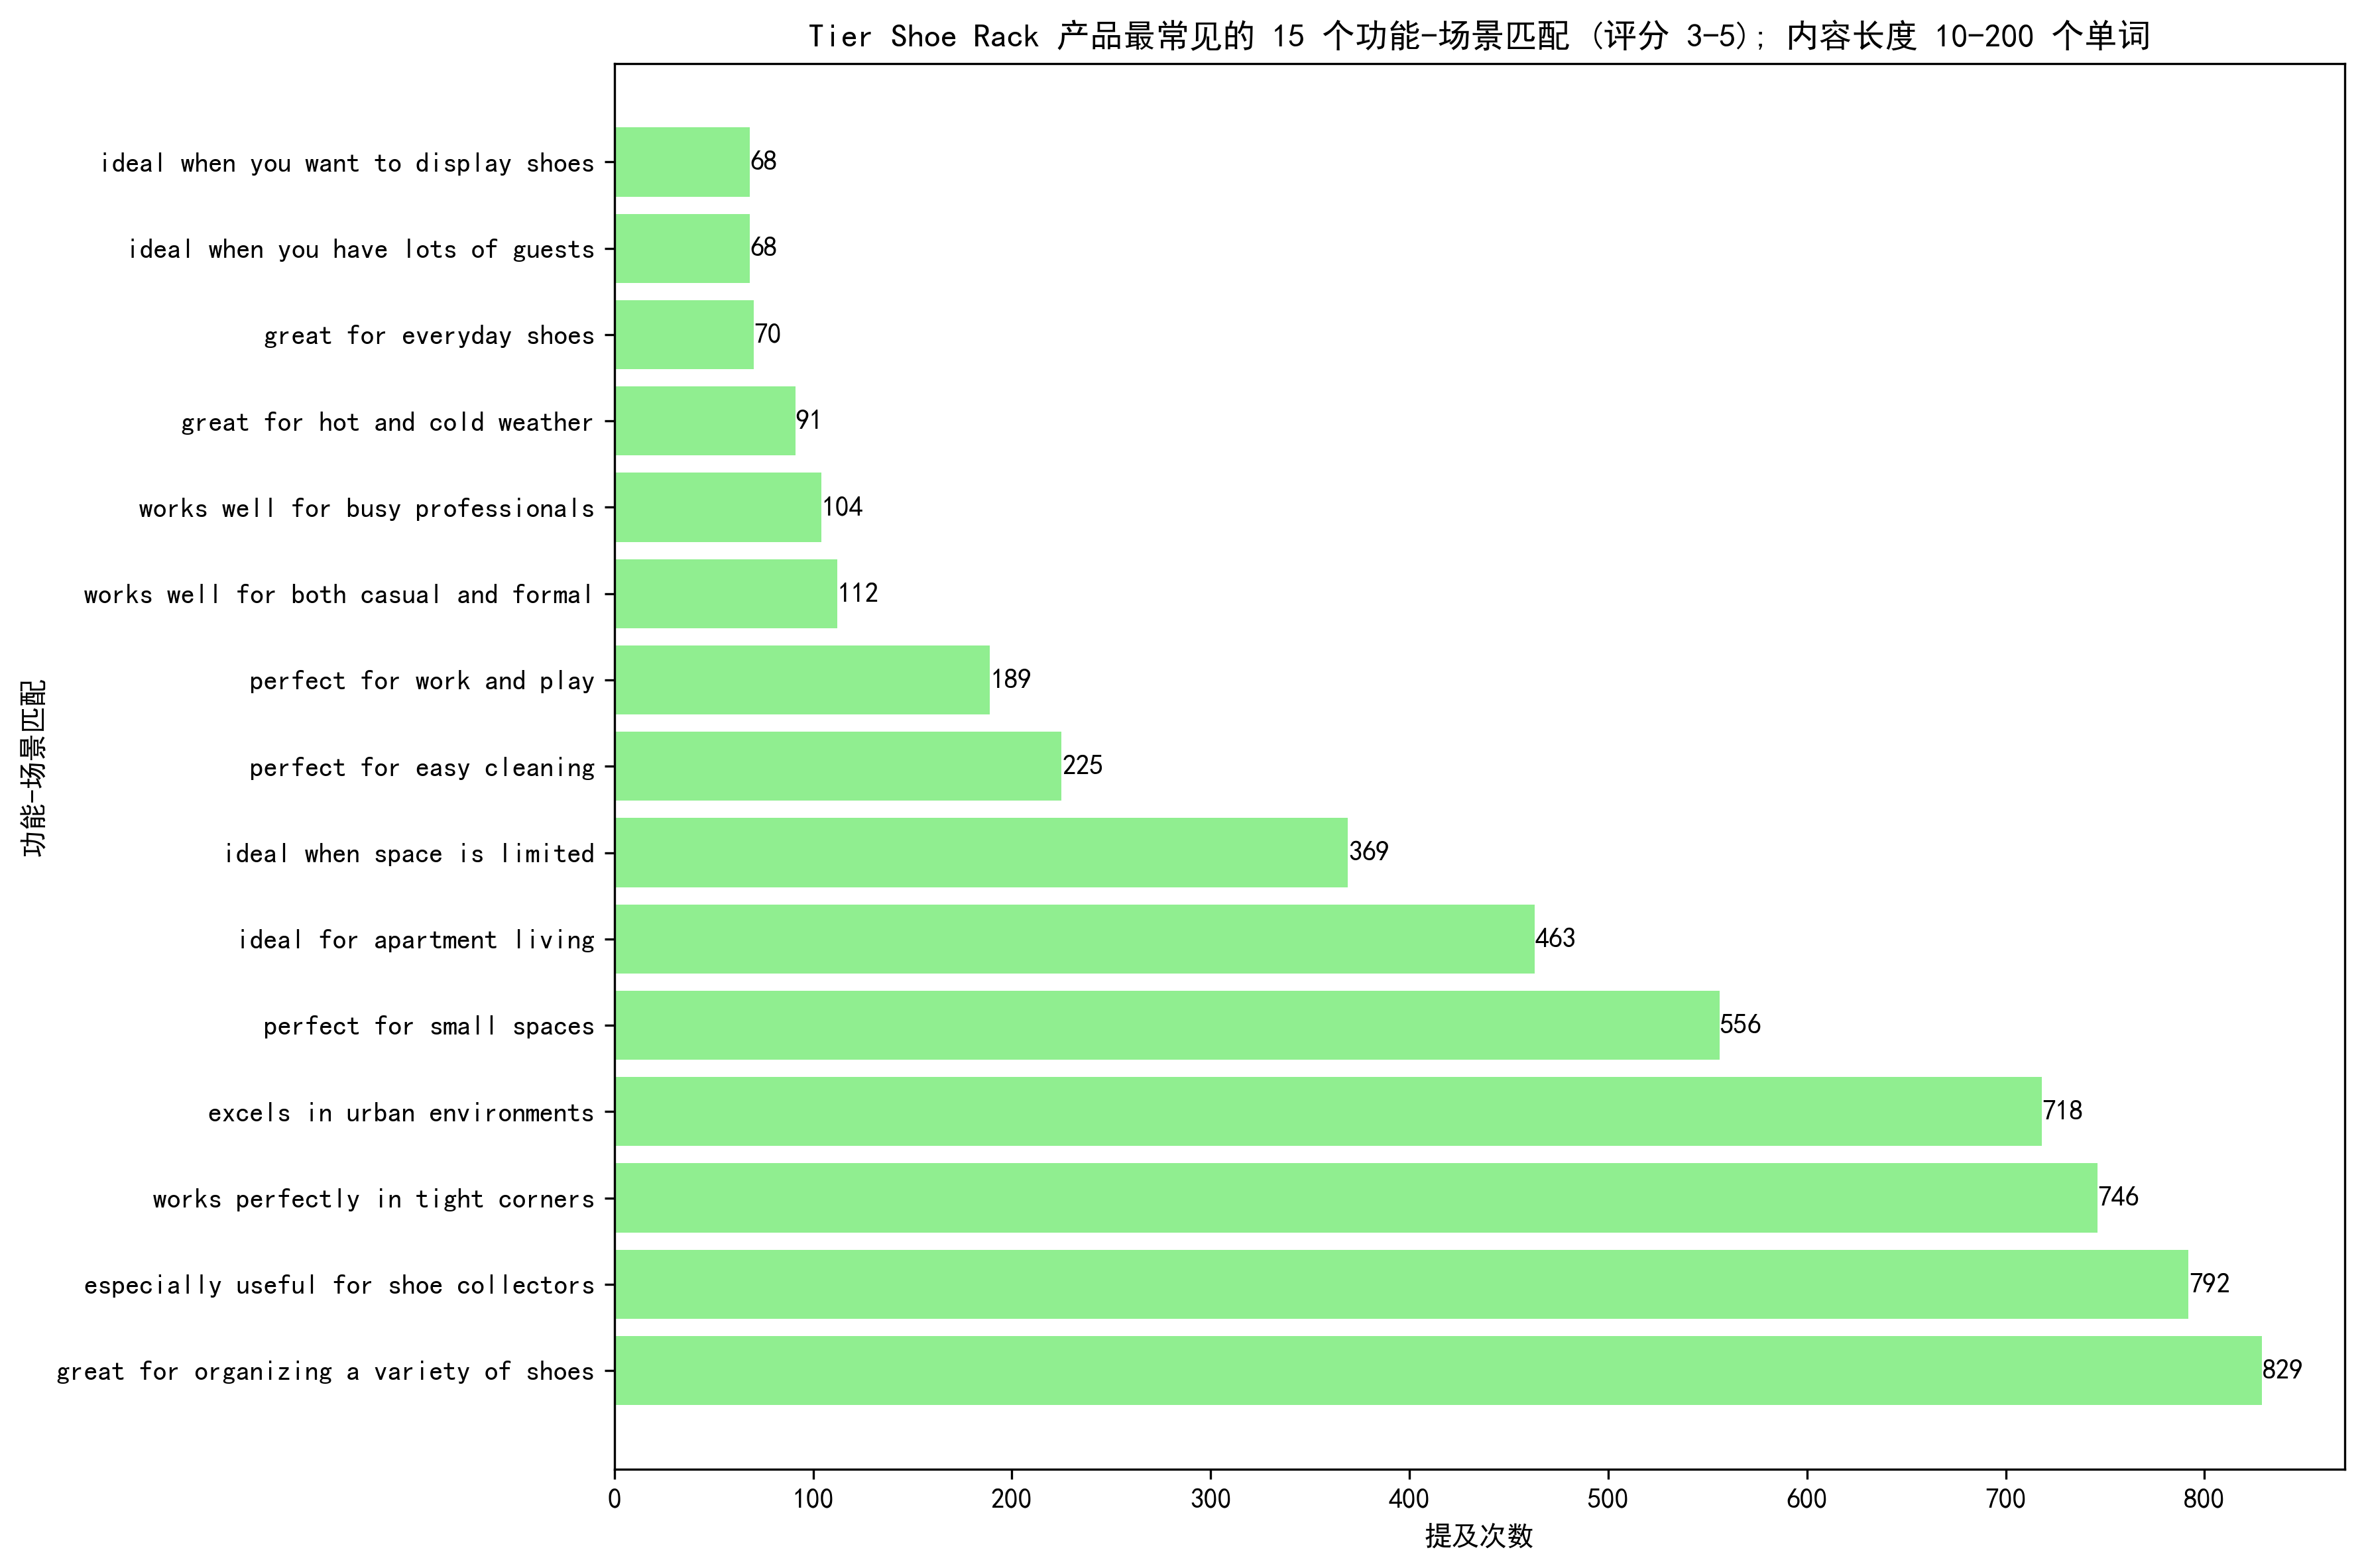


功能-场景匹配分析完成，耗时: 12.67 秒

分析条件:
- 产品类型: Tier Shoe Rack
- 评分范围: 3-5
- 内容长度: 10-200 个单词

功能-场景匹配频率分析结果:
没有找到任何功能-场景匹配信息: 未知错误
将继续使用QWen-Max进行分析...


In [15]:
import os
import sys
import time
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from IPython.display import display
from tqdm.notebook import tqdm
import glob


def find_voc_file():
    # 查找Data文件夹中所有以"VOC数据.xlsx"结尾的文件
    voc_files = glob.glob("Data/*VOC数据.xlsx")
    
    if voc_files:
        # 如果找到多个匹配的文件，返回最新的一个（按文件修改时间排序）
        return sorted(voc_files, key=os.path.getmtime, reverse=True)[0]
    else:
        # 如果没有找到匹配的文件，抛出错误
        raise FileNotFoundError("未找到任何以'VOC数据.xlsx'结尾的文件")

# 保持原始变量名不变
file_path = find_voc_file()
print(f"使用的文件路径: {file_path}")

with open('Data/产品类别.txt', 'r', encoding='utf-8') as f:
    product_type = f.read().strip()

# 3. 验证变量内容
print(f"product_type变量的值为: '{product_type}'")
print(f"变量类型: {type(product_type)}")
rating_range = (3, 5)
content_length_range = (10, 200)
content_length_method = 'words'
content_column = 'content'

print("===== 第一阶段：功能-场景匹配分析 =====")
start_time = time.time()

# 读取原始数据
try:
    print(f"尝试读取Excel文件: {file_path}...")
    try:
        # 首先尝试读取Excel文件
        original_df = pd.read_excel(file_path)
        print(f"成功读取Excel文件")
    except Exception as ex:
        print(f"读取Excel文件失败: {str(ex)}")
        print("尝试作为CSV文件读取...")
        
        # 如果Excel读取失败，尝试多种编码读取为CSV
        encodings = ['utf-8', 'gbk', 'gb18030', 'latin1']
        original_df = None
        
        for encoding in encodings:
            try:
                print(f"尝试使用 {encoding} 编码读取CSV文件...")
                original_df = pd.read_csv(file_path, encoding=encoding)
                print(f"成功使用 {encoding} 编码读取CSV文件")
                break
            except UnicodeDecodeError:
                print(f"使用 {encoding} 编码读取失败")
                continue
            except Exception as ex:
                print(f"读取时发生其他错误: {str(ex)}")
                continue
        
        if original_df is None:
            # 最后的尝试：使用errors='replace'参数
            try:
                print("尝试使用 'utf-8' 编码和 errors='replace' 参数读取CSV...")
                original_df = pd.read_csv(file_path, encoding='utf-8', errors='replace')
                print("成功读取CSV文件，但某些字符可能已被替换")
            except Exception as ex:
                print(f"所有读取方法均失败: {str(ex)}")
                sys.exit(1)
    
    print(f"原始数据包含 {len(original_df)} 条记录")
except Exception as ex:
    print(f"读取文件时发生未预期错误: {str(ex)}")
    sys.exit(1)


# 创建进度条
with tqdm(total=100, desc="正在分析功能-场景匹配") as pbar:
    def update_progress(progress):
        pbar.update(progress - pbar.n)
    
    results = analyze_product_matches(
        file_path=file_path, 
        product_type=product_type, 
        rating_range=rating_range,
        content_length_range=content_length_range,
        content_length_method=content_length_method,
        content_column=content_column,
        debug_mode=False,
        progress_callback=update_progress
    )
    
    pbar.update(100 - pbar.n)

end_time = time.time()
print(f"\n功能-场景匹配分析完成，耗时: {end_time - start_time:.2f} 秒")

# 显示筛选条件
print(f"\n分析条件:")
print(f"- 产品类型: {product_type}")
if rating_range:
    print(f"- 评分范围: {rating_range[0]}-{rating_range[1]}")
if content_length_range:
    min_len = content_length_range[0] if content_length_range[0] is not None else "任意"
    max_len = content_length_range[1] if content_length_range[1] is not None else "任意" 
    unit = "个字符" if content_length_method == "chars" else "个单词"
    print(f"- 内容长度: {min_len}-{max_len} {unit}")

# 确保输出目录存在
output_dir = "生成结果/matches_analysis/"
os.makedirs(output_dir, exist_ok=True)

print("\n功能-场景匹配频率分析结果:")
if results and results.get('success') and 'matches_stats' in results and len(results.get('matches_stats', [])) > 0:
    # 显示结果
    display(results['matches_stats'].head(10))
    
    # 创建一个映射字典，记录每个Match在哪些评论中出现
    match_to_reviews_map = {}
    
    # 首先，检查process_dataframe_for_matches函数的返回结果，这是最原始的功能-场景匹配-评论关系
    matches_df = results.get('matches_df')
    if isinstance(matches_df, pd.DataFrame) and len(matches_df) > 0 and 'Match' in matches_df.columns:
        print(f"从原始处理结果中提取功能-场景匹配-评论关系，共 {len(matches_df)} 条记录")
        
        # 检查matches_df的列
        print(f"原始matches_df的列: {matches_df.columns.tolist()}")
        
        # 从matches_df中提取功能-场景匹配与评论的关系
        for _, row in matches_df.iterrows():
            match = row.get('Match')
            if match:
                # 获取评论索引 - 检查可能的列名
                review_idx = None
                if 'Review_Index' in matches_df.columns:
                    review_idx = row.get('Review_Index')
                elif 'index' in matches_df.columns:
                    review_idx = row.get('index')
                
                # 获取评论文本 - 检查content_column是否存在
                review_text = None
                if content_column in matches_df.columns:
                    review_text = row.get(content_column)
                elif 'ReviewText' in matches_df.columns:
                    review_text = row.get('ReviewText')
                
                # 如果索引和文本都有效，添加到映射字典
                if review_idx is not None and review_text is not None and isinstance(review_text, str):
                    if match not in match_to_reviews_map:
                        match_to_reviews_map[match] = []
                    match_to_reviews_map[match].append((review_idx, review_text))
    
    # 处理所有输出文件
    for file_key, file_path in results['files'].items():
        # 修改输出路径到指定的功能-场景匹配目录
        original_filename = os.path.basename(file_path) if file_path else f"match_analysis_{file_key}.xlsx"
        # 将CSV文件名转换为xlsx文件名
        if original_filename.endswith('.csv'):
            original_filename = original_filename.replace('.csv', '.xlsx')
        new_file_path = os.path.join(output_dir, original_filename)
        
        if file_path and os.path.exists(file_path) and file_path.endswith('.csv'):
            # 读取CSV文件
            try:
                df = pd.read_csv(file_path, encoding='utf-8-sig')
            except:
                try:
                    df = pd.read_csv(file_path, encoding='utf-8')
                except:
                    try:
                        df = pd.read_csv(file_path, encoding='gbk')
                    except Exception as e:
                        print(f"错误: 无法读取CSV文件: {file_path}, 错误: {e}")
                        continue
            
            # 删除Context列
            if 'Context' in df.columns:
                df = df.drop(columns=['Context'])
            
            # 重新构建Review_Indices和ReviewText列
            df['Review_Indices'] = None
            df['ReviewText'] = None
            
            # 为每个功能-场景匹配找到匹配的评论
            if 'Match' in df.columns and 'Count' in df.columns:
                for i, row in df.iterrows():
                    try:
                        match = str(row['Match']) if not pd.isna(row['Match']) else ""
                        count = int(row['Count']) if not pd.isna(row['Count']) else 0
                        
                        # 如果match为空或count为0，填充空列表
                        if not match or count <= 0:
                            df.at[i, 'Review_Indices'] = json.dumps([])
                            df.at[i, 'ReviewText'] = json.dumps([])
                            continue
                        
                        # 首先检查映射字典中是否已有该功能-场景匹配的评论关系
                        matching_rows = []
                        if match in match_to_reviews_map:
                            # 使用已知的功能-场景匹配-评论关系
                            matching_rows = match_to_reviews_map[match]
                            print(f"从映射字典中找到功能-场景匹配 '{match}' 的 {len(matching_rows)} 条评论记录")
                        else:
                            # 在原始评论中搜索包含该功能-场景匹配的评论
                            keyword = match.lower()
                            print(f"在原始评论中搜索包含关键词 '{keyword}' 的评论")
                            
                            # 直接查找包含功能-场景匹配关键词的评论
                            for idx, orig_row in original_df.iterrows():
                                if content_column in orig_row and isinstance(orig_row[content_column], str):
                                    content = orig_row[content_column].lower()
                                    if keyword in content:
                                        matching_rows.append((idx, orig_row[content_column]))
                                        if len(matching_rows) >= count:
                                            break
                        
                        # 记录找到的匹配评论数量
                        found_count = len(matching_rows)
                        
                        # 如果找不到足够的匹配项，使用明确的标记
                        if found_count < count:
                            print(f"警告: 功能-场景匹配 '{match}' 只找到 {found_count} 条匹配评论，少于所需的 {count} 条")
                            # 不再随机填充，而是使用明确的标记
                            for _ in range(count - found_count):
                                matching_rows.append((-1, "未找到匹配评论"))
                        
                        # 确保不超过count
                        matching_rows = matching_rows[:count]
                        
                        # 提取索引和文本
                        indices = [int(row[0]) for row in matching_rows]
                        reviews = [str(row[1]) for row in matching_rows]
                        
                        # 更新DataFrame
                        df.at[i, 'Review_Indices'] = json.dumps(indices)
                        df.at[i, 'ReviewText'] = json.dumps(reviews)
                    except Exception as e:
                        print(f"错误: 处理功能-场景匹配'{row.get('Match', '')}' 时出错: {e}")
                        # 使用明确的错误标记
                        df.at[i, 'Review_Indices'] = json.dumps([-999] * count)  # 使用-999表示处理错误
                        df.at[i, 'ReviewText'] = json.dumps(["处理错误"] * count)
                
                # 保存到新路径，改为Excel格式
                df.to_excel(new_file_path, index=False)
                print(f"\n已处理文件并保存到: {new_file_path}")
                print(f"- 删除了Context列(如果存在)")
                print(f"- 已填充Review_Indices和ReviewText列")
                print(f"- 当前文件包含的列: {', '.join(df.columns.tolist())}")
                
                # 更新结果中的文件路径
                results['files'][file_key] = new_file_path
                
                # 验证Count与Review_Indices长度是否一致
                mismatch_count = 0
                for i, row in df.iterrows():
                    try:
                        indices = json.loads(row['Review_Indices'])
                        count = int(row['Count'])
                        if len(indices) != count:
                            mismatch_count += 1
                            if mismatch_count <= 5:  # 只显示前5个不匹配的情况
                                print(f"错误: 行 {i} 的功能-场景匹配 '{row['Match']}' 的索引数量({len(indices)})与Count({count})不一致")
                            elif mismatch_count == 6:
                                print("更多不匹配情况省略...")
                    except Exception as e:
                        print(f"错误: 验证行 {i} 时出错: {e}")
                
                if mismatch_count == 0:
                    print("验证完成: 所有功能-场景匹配的索引数量与Count一致")
                else:
                    print(f"验证完成: 发现 {mismatch_count} 个功能-场景匹配的索引数量与Count不一致")
    
    print(f"\n功能-场景匹配分析结果已保存到:")
    print(f"分析结果: {results['files'].get('result', '未知')}")
    print(f"图表: {results['files'].get('chart', '未知')}")
else:
    error_msg = results.get('error', "未知错误") if results else "分析未返回结果"
    print(f"没有找到任何功能-场景匹配信息: {error_msg}")
    print("将继续使用QWen-Max进行分析...")
    
    if not results or not results.get('success'):
        # 确保输出目录存在
        temp_dir = os.path.join("生成结果", "matches_analysis")
        os.makedirs(temp_dir, exist_ok=True)
        temp_file = os.path.join(temp_dir, f"temp_match_analysis.xlsx")
        
        # 创建临时DataFrame，使用明确的标记
        count_value = 1
        temp_df = pd.DataFrame({
            'Match': ['功能-场景匹配分析失败'],
            'Count': [count_value],
            'Frequency': [0],
            'Avg_Rating': [0],
            'Review_Indices': [json.dumps([-1] * count_value)],  # 使用-1表示未找到匹配
            'ReviewText': [json.dumps(["未找到匹配评论"] * count_value)]
        })
        temp_df.to_excel(temp_file, index=False)
        
        results = {
            'matches_stats': temp_df,
            'matches_df': pd.DataFrame(),
            'files': {'result': temp_file, 'chart': None},
            'save_path': temp_file,
            'success': True
        }

In [16]:
# 在代码开始处添加
%matplotlib inline
import matplotlib.pyplot as plt

# 步骤2: QWen-Max高级筛选
print("\n===== 第二阶段：QWen-Max精确筛选 =====")
start_time = time.time()

# 初始化QWen客户端
qwen_client = None
language = "english"  # 根据需要修改语言

try:
    # 从环境变量或配置文件中获取API密钥
    import os
    api_key = os.environ.get("QWEN_API_KEY") or API_KEY  # 假设API_KEY已在其他地方定义
    
    # 初始化OpenAI兼容的客户端
    if api_key:
        from openai import OpenAI
        qwen_client = OpenAI(
            api_key=api_key,  # 不需要引号，这是变量
            base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
        )
        print("QWen-Max客户端初始化成功")
    else:
        print("警告: 未找到API密钥，将跳过QWen-Max筛选")
        
except Exception as e:
    print(f"QWen-Max客户端初始化失败: {str(e)}")
    qwen_client = None

# 创建第二个进度条
with tqdm(total=100, desc="QWen-Max正在筛选数据") as pbar:
    # 假设refine_latest_matches_analysis函数支持回调以更新进度条
    def update_progress(progress):
        pbar.update(progress - pbar.n)
    
    refined_results = refine_latest_matches_analysis(
        results=results, 
        progress_callback=update_progress,
        qwen_client=qwen_client,
        language=language
    )
    
    # 确保进度条到达100%
    pbar.update(100 - pbar.n)

end_time = time.time()
print(f"\nQWen-Max筛选完成，耗时: {end_time - start_time:.2f} 秒")

# 显示筛选后的结果
# 显示筛选后的结果
if refined_results:
    print("\nQWen-Max筛选后的结果概览:")
    if 'matches_stats' in refined_results and refined_results['matches_stats'] is not None:
        display(refined_results['matches_stats'].head(10))  # 只显示前10条
    
    # 确保输出路径是.xlsx格式
    if 'save_path' in refined_results and refined_results['save_path'] is not None:
        if refined_results['save_path'].endswith('.csv'):
            new_save_path = refined_results['save_path'].replace('.csv', '.xlsx')
            
            # 读取文件并保存为XLSX
            df = None
            try:
                # 首先尝试读取Excel文件
                try:
                    df = pd.read_excel(refined_results['save_path'])
                    print(f"成功读取Excel文件: {refined_results['save_path']}")
                except Exception as excel_error:
                    print(f"尝试读取Excel文件失败，将尝试读取CSV: {excel_error}")
                    
                    # 如果读取Excel失败，尝试读取CSV文件
                    try:
                        df = pd.read_csv(refined_results['save_path'], encoding='utf-8-sig')
                        print(f"成功读取CSV文件(utf-8-sig): {refined_results['save_path']}")
                    except:
                        try:
                            df = pd.read_csv(refined_results['save_path'], encoding='utf-8')
                            print(f"成功读取CSV文件(utf-8): {refined_results['save_path']}")
                        except:
                            try:
                                df = pd.read_csv(refined_results['save_path'], encoding='gbk')
                                print(f"成功读取CSV文件(gbk): {refined_results['save_path']}")
                            except Exception as e:
                                print(f"错误: 无法读取文件: {refined_results['save_path']}, 错误: {e}")
                                df = None
                
                # 保存为Excel (仅当df不为None时)
                if df is not None:
                    df.to_excel(new_save_path, index=False)
                    print(f"已将结果从CSV转换为Excel格式")
                    
                    # 更新保存路径
                    refined_results['save_path'] = new_save_path
            except Exception as outer_error:
                print(f"转换过程中发生错误: {outer_error}")
    
    print(f"\n二次筛选的结果已保存到: {refined_results['save_path']}")
    # 使用'Match'和'Count'列绘制柱状图
    if 'matches_stats' in refined_results and len(refined_results['matches_stats']) > 0:
        matches_df = refined_results['matches_stats']
        
        # 确保Match和Count列存在
        if 'Match' in matches_df.columns and 'Count' in matches_df.columns:
            # 尝试获取中文字体
            try:
                for font_name in ['SimHei', 'Microsoft YaHei', 'SimSun', 'Arial Unicode MS']:
                    try:
                        font = FontProperties(family=font_name)
                        plt.rcParams['font.family'] = font_name
                        break
                    except:
                        continue
            except:
                pass  # 如果无法设置中文字体，使用默认字体
                
            # 对数据按Count列排序，取前15个
            top_n = min(15, len(matches_df))
            top_matches = matches_df.sort_values('Count', ascending=False).head(top_n)
            
            plt.figure(figsize=(12, 8))
            bars = plt.barh(top_matches['Match'], top_matches['Count'], color='skyblue')
            plt.xlabel('匹配出现次数')
            plt.ylabel('功能-场景匹配')
            
            title = f'{product_type} 产品筛选后的 {top_n} 个主要功能-场景匹配'
            if rating_range:
                title += f' (评分 {rating_range[0]}-{rating_range[1]})'
            plt.title(title)
            
            plt.tight_layout()
            
            # 在每个条形上添加计数标签
            for bar in bars:
                width = bar.get_width()
                plt.text(width + 0.3, bar.get_y() + bar.get_height()/2, 
                         f'{width:.0f}', ha='left', va='center')
            
            # 确保输出目录存在
            chart_dir = os.path.join("生成结果", "matches_analysis")
            os.makedirs(chart_dir, exist_ok=True)
            
            # 保存精选功能-场景匹配图表
            refined_chart_file = os.path.splitext(refined_results['save_path'])[0] + "_chart.png"
            plt.savefig(refined_chart_file, dpi=300, bbox_inches='tight')
            print(f"图表已保存到: {refined_chart_file}")
            
            # 在Jupyter中显示图表
            # from IPython.display import display, Image
            # display(Image(filename=refined_chart_file))
            # 显示图表 - 确保图表显示
            # plt.ion()  # 开启交互模式
            # plt.show()
            # plt.pause(0.1)  # 暂停一下确保图表显示
            print(f"精选功能-场景匹配图表已保存到: {refined_chart_file}")
        else:
            print(f"警告: 无法绘制图表 - 缺少必要的列。现有列: {matches_df.columns.tolist()}")
else:
    print("QWen-Max筛选未产生有效结果")

print("\n===== 功能-场景匹配分析流程完成 =====")


===== 第二阶段：QWen-Max精确筛选 =====


QWen-Max客户端初始化成功


QWen-Max正在筛选数据:   0%|          | 0/100 [00:00<?, ?it/s]

开始精炼匹配分析结果...
从文件读取完整数据: 生成结果\matches_analysis\致欧-2025-01-10之后VOC数据_rating_3_to_5_length_10_to_200_words_matches_analysis.xlsx
从文件读取完整数据: 生成结果\matches_analysis\致欧-2025-01-10之后VOC数据_rating_3_to_5_length_10_to_200_words_matches_analysis.xlsx
尝试读取Excel文件: 生成结果\matches_analysis\致欧-2025-01-10之后VOC数据_rating_3_to_5_length_10_to_200_words_matches_analysis.xlsx
成功读取Excel文件
成功从CSV读取的列: ['Match', 'Count', 'Frequency', 'Avg_Rating', 'Importance_Score', 'Review_Indices', 'ReviewText', 'Context']
使用QWen-Max筛选有意义的产品匹配...
筛选前数据框列: ['Match', 'Count', 'Frequency', 'Avg_Rating', 'Importance_Score', 'Review_Indices', 'ReviewText', 'Context']


QWen-Max返回: []
API调用成功，但没有有效的匹配项，返回空的功能-场景匹配DataFrame
QWen-Max筛选后保留了0个匹配，包含以下列: ['Match', 'Count', 'Frequency', 'Avg_Rating', 'Importance_Score', 'Review_Indices', 'ReviewText', 'Context']
已保存精炼后的匹配分析到: 生成结果\matches_analysis\refined_致欧-2025-01-10之后VOC数据_rating_3_to_5_length_10_to_200_words_matches_analysis.xlsx
保存的CSV文件包含以下列: ['Match', 'Count', 'Frequency', 'Avg_Rating', 'Importance_Score', 'Review_Indices', 'ReviewText', 'Context']
匹配精炼完成，共保留了 0 个匹配类别

QWen-Max筛选完成，耗时: 1.83 秒

QWen-Max筛选后的结果概览:


,Match,Count,Frequency,Avg_Rating,Importance_Score,Review_Indices,ReviewText,Context



二次筛选的结果已保存到: 生成结果\matches_analysis\refined_致欧-2025-01-10之后VOC数据_rating_3_to_5_length_10_to_200_words_matches_analysis.xlsx

===== 功能-场景匹配分析流程完成 =====


In [17]:
# 使用简单prompt测试API连通性
test_response = qwen_client.chat.completions.create(
    model="qwen-max",
    messages=[{"role": "user", "content": "回复'OK'"}]
)
print(test_response.choices[0].message.content)  # 预期输出"OK"

OK
